In [1]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Mengambil spektrum dari semua sampel dan menggabungkan iterasi
def get_all_spectra(db_path, sample_names, lower_bound=350, upper_bound=400):
    all_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                spectra.append((wavelengths, intensities))
        all_spectra[sample_name] = spectra
    return all_spectra

# 1. Smoothing using Savitzky-Golay filter
def smooth_spectrum(intensity, window_length=11, polyorder=3):
    return savgol_filter(intensity, window_length, polyorder)

# 2. Baseline correction using ALS (Asymmetric Least Squares) with SciPy
def baseline_correction_als(intensity, lam=1e6, p=0.01, niter=10):
    L = len(intensity)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.diags(w, 0)
        Z = W + lam * D.dot(D.transpose())
        baseline = spsolve(Z, w * intensity)
        w = p * (intensity > baseline) + (1 - p) * (intensity < baseline)
    return baseline

# 3. Outlier removal using Z-score
def remove_outliers(intensity, threshold=3):
    z_scores = zscore(intensity)
    mask = np.abs(z_scores) < threshold
    return intensity[mask]

# 4. Normalisasi dengan PCA
def normalize_spectra_with_pca(spectra):
    # Gabungkan intensitas dari ketiga iterasi menjadi satu matriks
    combined_intensities = np.vstack([spectra[0][1], spectra[1][1], spectra[2][1]]).T

    # Terapkan PCA pada intensitas gabungan
    pca = PCA(n_components=1)  # Komponen pertama
    pc1 = pca.fit_transform(combined_intensities)

    # Normalisasi dengan komponen utama pertama
    iter1_pca_normalized = spectra[0][1] / np.abs(pc1).max()
    iter2_pca_normalized = spectra[1][1] / np.abs(pc1).max()
    iter3_pca_normalized = spectra[2][1] / np.abs(pc1).max()

    return [iter1_pca_normalized, iter2_pca_normalized, iter3_pca_normalized]

# 5. Rata-rata intensitas yang dinormalisasi
def average_normalized_spectra(wavelengths, normalized_intensities):
    avg_intensity = np.mean(normalized_intensities, axis=0)
    return wavelengths, avg_intensity

# Pipeline Proses Lengkap untuk 1 sampel dengan 3 iterasi
def process_spectrum_pipeline(wavelengths, intensities_list):
    # Gabungkan intensitas dari ketiga iterasi untuk diproses bersama
    processed_spectra = []
    
    for intensities in intensities_list:
        # 1. Smoothing
        smoothed_intensity = smooth_spectrum(intensities)
        
        # 2. Baseline Correction menggunakan ALS
        baseline = baseline_correction_als(smoothed_intensity)
        baseline_corrected_intensity = smoothed_intensity - baseline
        
        processed_spectra.append(baseline_corrected_intensity)
    
    # 3. Normalisasi dengan PCA (dengan komponen utama PC1)
    normalized_intensities = normalize_spectra_with_pca([(wavelengths, processed_spectra[0]),
                                                         (wavelengths, processed_spectra[1]),
                                                         (wavelengths, processed_spectra[2])])

    # 4. Removal Outliers dengan Z-score
    cleaned_intensities = [remove_outliers(intensity) for intensity in normalized_intensities]

    # 5. Rata-rata intensitas
    avg_intensity = average_normalized_spectra(wavelengths, cleaned_intensities)
    
    return avg_intensity

# Path ke database dan nama-nama sampel
db_path = 'tanah_vulkanik.db'
sample_names = [f'S{i}' for i in range(1, 7)]  # Contoh: 6 sampel

# Mengambil dan menggabungkan spektrum
all_spectra = get_all_spectra(db_path, sample_names)

# Normalisasi dan hitung rata-rata spektrum untuk setiap sampel
processed_spectra = {}
for sample_name, spectra in all_spectra.items():
    wavelengths = spectra[0][0]
    intensities_list = [s[1] for s in spectra]  # Mengambil intensitas dari ketiga iterasi
    
    # Proses ketiga iterasi menjadi satu spektrum per sampel
    avg_intensity = process_spectrum_pipeline(wavelengths, intensities_list)
    processed_spectra[sample_name] = avg_intensity

# Plot scatter dengan offset y untuk setiap sampel
plt.figure(figsize=(10, 6))
offset = 1  # Offset untuk setiap sampel pada sumbu y
for i, (sample_name, (wavelengths, avg_intensity)) in enumerate(processed_spectra.items()):
    plt.plot(wavelengths, avg_intensity + i * offset, label=f'{sample_name} (y offset {i * offset:.1f})', linewidth=0.4)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity (with y offset)')
plt.title('Normalized Spectra of Samples with ALS Baseline Correction')
plt.legend()
plt.grid(True)

# Save as PDF
plt.savefig('normalized_spectra_with_als.pdf', format='pdf')

# Show plot
plt.show()

/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_7095/505194062.py:64: MatrixRankWarning: Matrix is exactly singular
  baseline = spsolve(Z, w * intensity)


dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331
dgstrf info 4331


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Mengambil spektrum dari semua sampel dan menggabungkan iterasi
def get_all_spectra(db_path, sample_names, lower_bound=200, upper_bound=900):
    all_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                spectra.append((wavelengths, intensities))
        all_spectra[sample_name] = spectra
    return all_spectra

# Normalisasi dan rata-rata spektrum untuk rentang 200-900 nm
def normalize_and_average_spectra(all_spectra):
    normalized_averaged_spectra = {}

    for sample_name, spectra in all_spectra.items():
        if len(spectra) == 3:
            # Gabungkan intensitas dari ketiga iterasi menjadi satu matriks
            combined_intensities = np.vstack([spectra[0][1], spectra[1][1], spectra[2][1]]).T

            # Terapkan PCA pada intensitas gabungan
            pca = PCA(n_components=1)  # Komponen pertama
            pc1 = pca.fit_transform(combined_intensities)

            # Normalisasi setiap iterasi dengan komponen utama pertama (PC1)
            iter1_pca_normalized = spectra[0][1] / np.abs(pc1).max()
            iter2_pca_normalized = spectra[1][1] / np.abs(pc1).max()
            iter3_pca_normalized = spectra[2][1] / np.abs(pc1).max()

            # Hitung rata-rata intensitas dari ketiga iterasi yang dinormalisasi
            avg_intensity = np.mean([iter1_pca_normalized, iter2_pca_normalized, iter3_pca_normalized], axis=0)

            # Simpan hasil rata-rata intensitas dengan panjang gelombang
            normalized_averaged_spectra[sample_name] = (spectra[0][0], avg_intensity)

    return normalized_averaged_spectra

# Fungsi untuk memotong spektrum sesuai batas bawah dan atas yang diinginkan
def cut_spectra(normalized_averaged_spectra, lower_bound, upper_bound):
    cut_spectra = {}
    for sample_name, (wavelengths, avg_intensity) in normalized_averaged_spectra.items():
        mask = (wavelengths >= lower_bound) & (wavelengths <= upper_bound)
        cut_spectra[sample_name] = (wavelengths[mask], avg_intensity[mask])
    return cut_spectra

# Path ke database dan nama-nama sampel
db_path = 'tanah_vulkanik.db'

# Asumsi pembagian sampel, setiap tiga sampel mewakili satu lokasi dengan kedalaman 20cm, 40cm, dan 60cm
sample_groups = [
    [f'S{i}' for i in range(1, 4)],  # Lokasi 1: Pulo, Seulimum
    [f'S{i}' for i in range(4, 7)],  # Lokasi 2: Lam Apeng, Seulimum
    [f'S{i}' for i in range(7, 10)], # Lokasi 3: Leupung Bruek, Cot Glie
    [f'S{i}' for i in range(10, 13)],# Lokasi 4: Lambada, Seulimum
    [f'S{i}' for i in range(13, 16)],# Lokasi 5: Lon Baroh, Lembah Seulawah
    [f'S{i}' for i in range(16, 19)],# Lokasi 6: Teuladan, Lembah Seulawah
    [f'S{i}' for i in range(19, 22)],# Lokasi 7: Suka Damai, Lembah Seulawah
    [f'S{i}' for i in range(22, 25)] # Lokasi 8: Suka Mulia, Lembah Seulawah
]

# Informasi lokasi dan kedalaman yang sesuai
location_labels = [
    ('Pulo, Seulimum', ['40-60cm', '20-40cm', '0-20cm']),
    ('Lam Apeng, Seulimum', ['40-60cm', '20-40cm', '0-20cm']),
    ('Leupung Bruek, Cot Glie', ['40-60cm', '20-40cm', '0-20cm']),
    ('Lambada, Seulimum', ['40-60cm', '20-40cm', '0-20cm']),
    ('Lon Baroh, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm']),
    ('Teuladan, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm']),
    ('Suka Damai, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm']),
    ('Suka Mulia, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm'])
]

# Sebelum loop untuk pembuatan file PDF
lo = 800  # Nilai lower bound yang diinginkan, bisa disesuaikan
upo = 900  # Nilai upper bound yang diinginkan, bisa disesuaikan

# Ganti pdfname dengan:
pdfname = f'normalized_spectra_offset_24_samples_labeled_{lo}_{upo}.pdf'

# Membuat file PDF dengan banyak halaman
with PdfPages(pdfname) as pdf:
    for group_idx, sample_group in enumerate(sample_groups):
        # Mengambil dan menggabungkan spektrum untuk setiap lokasi
        all_spectra = get_all_spectra(db_path, sample_group, lower_bound=200, upper_bound=900)
        
        # Normalisasi dan hitung rata-rata spektrum untuk setiap sampel di rentang 200-900 nm
        normalized_averaged_spectra = normalize_and_average_spectra(all_spectra)

        # Potong spektrum sesuai dengan lower_bound dan upper_bound yang diinginkan
        cut_normalized_spectra = cut_spectra(normalized_averaged_spectra, lo, upo)

        # Plot setiap sampel dengan y-offset pada halaman yang berbeda
        plt.figure(figsize=(12, 8))
        offset = 1 # Offset untuk setiap sampel pada sumbu y
        for i, (sample_name, (wavelengths, avg_intensity)) in enumerate(cut_normalized_spectra.items()):
            plt.plot(wavelengths, avg_intensity + i * offset, label=f'{sample_name} ({location_labels[group_idx][1][i]})', linewidth=0.4)

        plt.ylim(0, 3)  # Batas sumbu y di antara 0 dan 4
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Normalized Intensity (with y offset)')
        plt.title(f'Normalized Spectra of Samples from {location_labels[group_idx][0]}')
        plt.legend()
        plt.grid(True)

        # Simpan halaman ini ke file PDF
        pdf.savefig()
        plt.close()

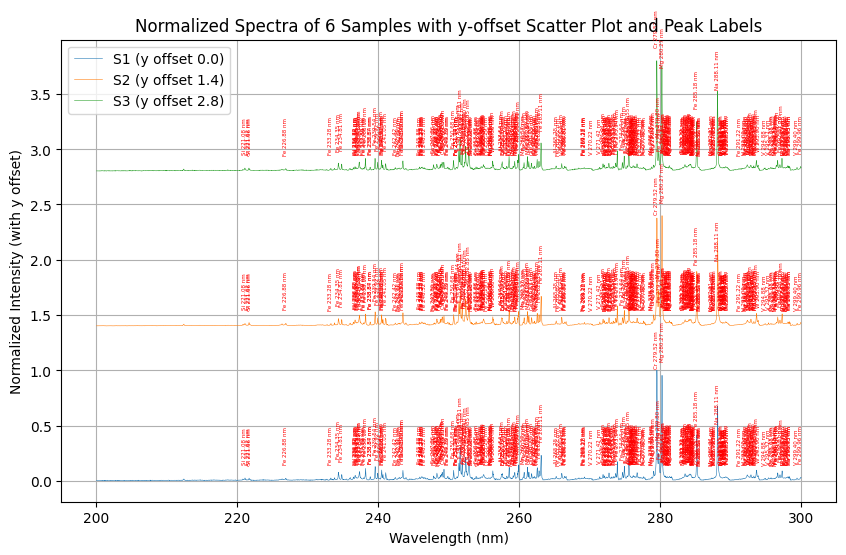

In [3]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Mengambil spektrum dari semua sampel dan menggabungkan iterasi
def get_all_spectra(db_path, sample_names, lower_bound=200, upper_bound=300):
    all_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                spectra.append((wavelengths, intensities))
        all_spectra[sample_name] = spectra
    return all_spectra

# Normalisasi dan rata-rata spektrum
def normalize_and_average_spectra(all_spectra):
    normalized_averaged_spectra = {}
    scaler = MinMaxScaler()
    
    for sample_name, spectra in all_spectra.items():
        if len(spectra) == 3:
            # Normalisasi setiap iterasi menggunakan MinMaxScaler
            iter1_normalized = scaler.fit_transform(spectra[0][1].reshape(-1, 1)).flatten()
            iter2_normalized = scaler.fit_transform(spectra[1][1].reshape(-1, 1)).flatten()
            iter3_normalized = scaler.fit_transform(spectra[2][1].reshape(-1, 1)).flatten()

            # Hitung rata-rata intensitas dari ketiga iterasi
            avg_intensity = np.mean([iter1_normalized, iter2_normalized, iter3_normalized], axis=0)

            # Simpan hasil rata-rata intensitas
            normalized_averaged_spectra[sample_name] = (spectra[0][0], avg_intensity)
    
    return normalized_averaged_spectra

# Fungsi untuk membaca file puncak terpilih (misalkan dalam format teks)
# Fungsi untuk membaca file puncak terpilih (dengan skip 4 baris pertama)
def read_peak_file(peak_file):
    peaks = []
    with open(peak_file, 'r') as file:
        lines = file.readlines()[4:]  # Skip 4 baris pertama
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 3:
                element = parts[0]
                wavelength = float(parts[2])
                peaks.append((element, wavelength))
    return peaks

# Fungsi untuk mencari puncak terdekat di spektrum eksperimen
def find_nearest_peak(experimental_wavelengths, peak_wavelength):
    idx = (np.abs(experimental_wavelengths - peak_wavelength)).argmin()
    return idx, experimental_wavelengths[idx]

# Path ke database dan nama-nama sampel
db_path = 'tanah_vulkanik.db'
sample_names = [f'S{i}' for i in range(1, 4)]  # Contoh: 6 sampel

# Mengambil dan menggabungkan spektrum
all_spectra = get_all_spectra(db_path, sample_names)

# Normalisasi dan hitung rata-rata spektrum untuk setiap sampel
normalized_averaged_spectra = normalize_and_average_spectra(all_spectra)

# Path ke file puncak terpilih (misalkan dalam format teks)
peak_file_path = '/Users/birrulwalidain/PycharmProjects/proyek-lIbs/S1(900.0-200.0)(0.5)(0920-0906).txt'

# Baca puncak terpilih dari file
peaks = read_peak_file(peak_file_path)

# Plot scatter dengan offset y untuk setiap sampel
plt.figure(figsize=(10, 6))
offset = 1.4  # Offset untuk setiap sampel pada sumbu y
for i, (sample_name, (wavelengths, avg_intensity)) in enumerate(normalized_averaged_spectra.items()):
    plt.plot(wavelengths, avg_intensity + i * offset, label=f'{sample_name} (y offset {i * offset:.1f})', linewidth=0.4)

    # Tambahkan label untuk setiap puncak terpilih
    for element, peak_wavelength in peaks:
        idx, nearest_wavelength = find_nearest_peak(wavelengths, peak_wavelength)
        plt.annotate(f'{element} {nearest_wavelength:.2f} nm', 
                     (nearest_wavelength, avg_intensity[idx] + i * offset),
                     textcoords="offset points", xytext=(0, 10), ha='center',va='bottom', fontsize=4, color='red', rotation='vertical')
        #plt.scatter(nearest_wavelength, avg_intensity[idx] + i * offset, color='red')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity (with y offset)')
plt.title('Normalized Spectra of 6 Samples with y-offset Scatter Plot and Peak Labels')
plt.legend()
plt.grid(True)

# Save as PDF
plt.savefig('normalized_spectra_with_peaks.pdf', format='pdf')

# Show plot
plt.show()

In [31]:
import sqlite3

# Fungsi untuk menambahkan kolom 'depth', 'location', dan 'location_point' ke tabel spektrum
def add_columns_to_table(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Menambahkan kolom 'depth' jika belum ada
    try:
        cursor.execute("ALTER TABLE spectrum_data ADD COLUMN depth TEXT")
        print("Kolom 'depth' berhasil ditambahkan.")
    except sqlite3.OperationalError:
        print("Kolom 'depth' sudah ada.")

    # Menambahkan kolom 'location' jika belum ada
    try:
        cursor.execute("ALTER TABLE spectrum_data ADD COLUMN location TEXT")
        print("Kolom 'location' berhasil ditambahkan.")
    except sqlite3.OperationalError:
        print("Kolom 'location' sudah ada.")
    
    # Menambahkan kolom 'location_point' untuk titik lokasi
    try:
        cursor.execute("ALTER TABLE spectrum_data ADD COLUMN location_point TEXT")
        print("Kolom 'location_point' berhasil ditambahkan.")
    except sqlite3.OperationalError:
        print("Kolom 'location_point' sudah ada.")

    conn.commit()
    conn.close()

# Fungsi untuk memperbarui data spektrum dengan kedalaman, lokasi, dan titik lokasi
def update_sample_info(db_path):
    # Data kedalaman, lokasi, dan titik lokasi untuk setiap sampel
    sample_info = {
        'S1': ('40-60', 'Pulo, Seulimum', 'A'),
        'S2': ('20-40', 'Pulo, Seulimum', 'A'),
        'S3': ('0-20', 'Pulo, Seulimum', 'A'),
        'S4': ('40-60', 'Lam Apeng, Seulimum', 'B'),
        'S5': ('20-40', 'Lam Apeng, Seulimum', 'B'),
        'S6': ('0-20', 'Lam Apeng, Seulimum', 'B'),
        'S7': ('40-60', 'Leupung Bruek, Cot Glie', 'A'),
        'S8': ('20-40', 'Leupung Bruek, Cot Glie', 'A'),
        'S9': ('0-20', 'Leupung Bruek, Cot Glie', 'A'),
        'S10': ('40-60', 'Lambada, Seulimum', 'B'),
        'S11': ('20-40', 'Lambada, Seulimum', 'B'),
        'S12': ('0-20', 'Lambada, Seulimum', 'B'),
        'S13': ('40-60', 'Lon Baroh, Lembah Seulawah', 'B'),
        'S14': ('20-40', 'Lon Baroh, Lembah Seulawah', 'B'),
        'S15': ('0-20', 'Lon Baroh, Lembah Seulawah', 'B'),
        'S16': ('40-60', 'Teuladan, Lembah Seulawah', 'A'),
        'S17': ('20-40', 'Teuladan, Lembah Seulawah', 'A'),
        'S18': ('0-20', 'Teuladan, Lembah Seulawah', 'A'),
        'S19': ('40-60', 'Suka Damai, Lembah Seulawah', 'A'),
        'S20': ('20-40', 'Suka Damai, Lembah Seulawah', 'A'),
        'S21': ('0-20', 'Suka Damai, Lembah Seulawah', 'A'),
        'S22': ('40-60', 'Suka Mulia, Lembah Seulawah', 'B'),
        'S23': ('20-40', 'Suka Mulia, Lembah Seulawah', 'B'),
        'S24': ('0-20', 'Suka Mulia, Lembah Seulawah', 'B')
    }

    # Memperbarui data spektrum dengan kedalaman, lokasi, dan titik lokasi
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    for sample_name, (depth, location, location_point) in sample_info.items():
        cursor.execute("""
            UPDATE spectrum_data
            SET depth = ?, location = ?, location_point = ?
            WHERE sample_name = ?
        """, (depth, location, location_point, sample_name))

    conn.commit()
    conn.close()
    print("Data sampel berhasil diperbarui dengan kedalaman, lokasi, dan titik lokasi.")

# Fungsi untuk menampilkan data setelah diperbarui
def verify_updates(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("SELECT sample_name, depth, location, location_point FROM spectrum_data")
    rows = cursor.fetchall()

    for row in rows:
        print(row)

    conn.close()

# Path ke database
db_path = 'tanah_vulkanik.db'

# Menambahkan kolom depth, location, dan location_point
add_columns_to_table(db_path)

# Memperbarui informasi sampel dengan kedalaman, lokasi, dan titik lokasi
update_sample_info(db_path)

# Verifikasi pembaruan
verify_updates(db_path)

Kolom 'depth' sudah ada.
Kolom 'location' sudah ada.
Kolom 'location_point' berhasil ditambahkan.
Data sampel berhasil diperbarui dengan kedalaman, lokasi, dan titik lokasi.


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



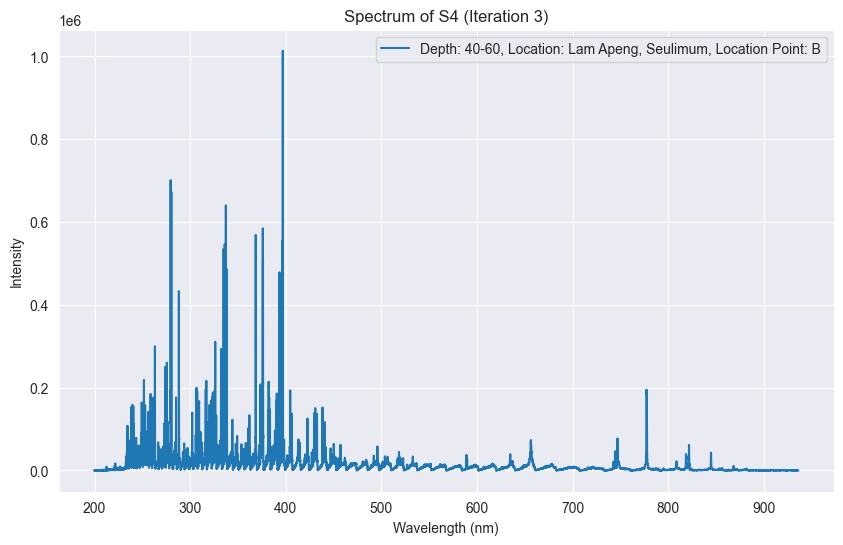

In [7]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum serta kedalaman, lokasi, dan titik lokasi (location_point) dari database
def get_spectrum_with_metadata(db_path, sample_name, iteration):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Ambil spektrum serta kedalaman, lokasi, dan titik lokasi (location_point)
    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name, iteration))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan titik lokasi (location_point)
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk membuat plot spektrum dengan legend depth, location, dan titik lokasi (location_point)
def plot_spectrum_with_metadata(db_path, sample_name, iteration):
    wavelengths, intensities, depth, location, location_point = get_spectrum_with_metadata(db_path, sample_name, iteration)

    if len(wavelengths) == 0:
        return  # Tidak ada data yang ditemukan

    # Plot spektrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, label=f'Depth: {depth}, Location: {location}, Location Point: {location_point}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f'Spectrum of {sample_name} (Iteration {iteration})')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Path ke database
db_path = 'tanah_vulkanik.db'

# Contoh plot spektrum dari salah satu sampel, misalnya S4 iterasi 1
sample_name = 'S4'
iteration = 3

# Plot spektrum
plot_spectrum_with_metadata(db_path, sample_name, iteration)

In [11]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fungsi untuk mengambil spektrum dari database serta kedalaman, lokasi, dan location_point
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# SNIP (Statistics-Sensitive Non-Linear Iterative Peak-Clipping) baseline correction
def baseline_correction_snip(intensity, iterations=100):
    L = len(intensity)
    baseline = np.copy(intensity)

    for i in range(iterations):
        for j in range(1, L - 1):
            baseline[j] = min(baseline[j], (baseline[j - 1] + baseline[j + 1]) / 2)
    return baseline

# Fungsi normalisasi dengan PCA
def normalize_spectra_with_pca(spectra):
    combined_intensities = np.vstack([spectra[0][1], spectra[1][1], spectra[2][1]]).T

    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(combined_intensities)

    iter1_pca_normalized = spectra[0][1] / np.abs(pc1).max()
    iter2_pca_normalized = spectra[1][1] / np.abs(pc1).max()
    iter3_pca_normalized = spectra[2][1] / np.abs(pc1).max()

    return [iter1_pca_normalized, iter2_pca_normalized, iter3_pca_normalized]

# Fungsi untuk menghitung rata-rata intensitas dari tiga iterasi
def average_normalized_spectra(wavelengths, normalized_intensities):
    avg_intensity = np.mean(normalized_intensities, axis=0)
    return wavelengths, avg_intensity

# Menyimpan hasil yang diproses ke database baru, termasuk depth, location, dan location_point
def save_to_new_db(db_path, processed_data):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS processed_spectrum (
            sample_name TEXT,
            wavelength REAL,
            intensity REAL
        )
    """)

    for sample_name, (wavelengths, intensities) in processed_data.items():
        for wavelength, intensity in zip(wavelengths, intensities):
            cursor.execute("""
                INSERT INTO processed_spectrum (sample_name, wavelength, intensity)
                VALUES (?, ?, ?)
            """, (sample_name, wavelength, intensity))
    
    conn.commit()
    conn.close()

# Mengambil spektrum dari semua sampel, melakukan baseline correction (opsional), normalisasi, dan PCA
def get_and_process_spectra(db_path, sample_names, lower_bound=200, upper_bound=900, use_baseline_correction=True):
    processed_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                if use_baseline_correction:
                    baseline = baseline_correction_snip(intensities)
                    baseline_corrected_intensity = intensities - baseline
                    spectra.append((wavelengths, baseline_corrected_intensity))
                else:
                    spectra.append((wavelengths, intensities))

        normalized_intensities = normalize_spectra_with_pca(spectra)
        wavelengths, avg_intensity = average_normalized_spectra(wavelengths, normalized_intensities)
        processed_spectra[sample_name] = (wavelengths, avg_intensity)
    return processed_spectra

# Path ke database lama dan database baru
old_db_path = 'kopii.db'
new_db_path = 'processed_spectra1.db'
sample_names = [f'{i}' for i in range(1, 14)]

# Pilih apakah akan menggunakan baseline correction atau tidak
use_baseline_correction = True

# Mengambil dan memproses spektrum
processed_spectra = get_and_process_spectra(old_db_path, sample_names, use_baseline_correction=use_baseline_correction)

# Simpan hasil yang telah diproses ke database baru
save_to_new_db(new_db_path, processed_spectra)

print(f"Data spektrum yang diproses telah disimpan ke {new_db_path}")

Data spektrum yang diproses telah disimpan ke processed_spectra1.db


PROSES 2

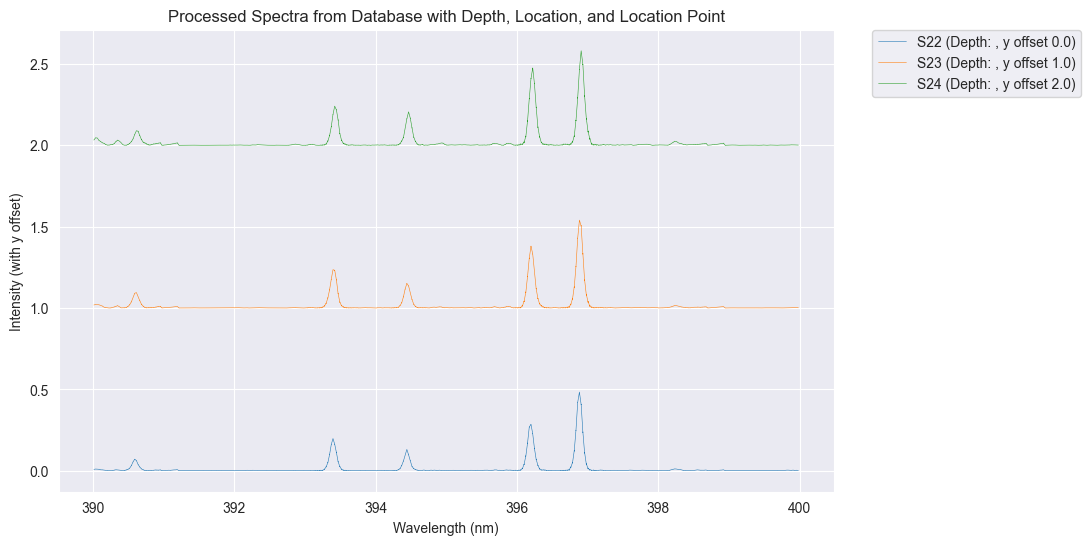

Plot spektrum yang diproses telah disimpan dalam format PDF dengan informasi depth, location, dan location_point.


In [4]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth, location, dan location_point
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([])

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan location_point

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths, dtype=float)
    intensities = np.array(intensities, dtype=float)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_processed_spectra(db_path, sample_names, output_pdf='processed_spectra_plot_with_metadata.pdf', lower_bound=None, upper_bound=None):
    plt.figure(figsize=(10, 6))
    offset = 1  # Offset untuk setiap sampel pada sumbu y
    for i, sample_name in enumerate(sample_names):
        wavelengths, intensities = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
        if len(wavelengths) > 0:
            # Menambahkan depth, location, dan location_point ke label pada plot
            plt.plot(wavelengths, intensities + i * offset, label=f'{sample_name} (Depth: , y offset {i * offset:.1f})', linewidth=0.4)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (with y offset)')
    plt.title('Processed Spectra from Database with Depth, Location, and Location Point')

    # Menempatkan legenda di luar kotak plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.grid(True)

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

    # Menampilkan plot
    plt.show()

# Path ke database baru
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(22, 25)]  # Mengambil contoh 6 sampel

# Menentukan batas panjang gelombang

lower_bound = 390  # Contoh: batas bawah panjang gelombang
upper_bound = 400
# Memproses dan menyimpan spektrum dengan batas panjang gelombang ke PDF, dengan depth, location, dan location_point
plot_and_save_processed_spectra(db_path, sample_names, 'processed_spectra_plot_with_bounds_and_metadata.pdf', lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam format PDF dengan informasi depth, location, dan location_point.")

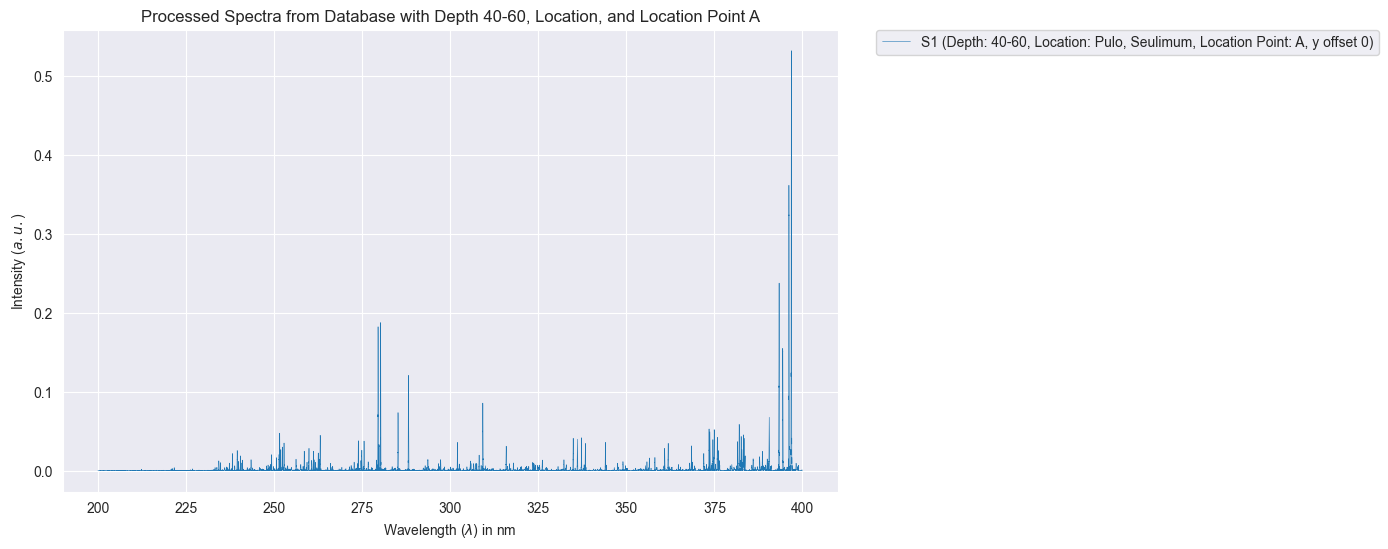

Plot spektrum yang diproses telah disimpan dalam format PDF dengan filter location_point A dan depth 40-60.


In [11]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth, location, dan location_point
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan location_point
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_processed_spectra(db_path, sample_names, output_pdf='processed_spectra_plot_with_metadata.pdf', lower_bound=None, upper_bound=None):
    plt.figure(figsize=(10, 6))
    offset = 1  # Offset tetap untuk setiap spektrum pada sumbu y
    plot_counter = 0  # Counter untuk menentukan berapa banyak spektrum yang sudah diplot
    
    for sample_name in sample_names:
        wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
        
        # Filter hanya untuk location_point A dan depth 40-60
        if location_point == 'A' and depth == '40-60' and len(wavelengths) > 0:
            # Menambahkan depth, location, dan location_point ke label pada plot
            plt.plot(wavelengths, intensities + plot_counter * offset, label=f'{sample_name} (Depth: {depth}, Location: {location}, Location Point: {location_point}, y offset {plot_counter * offset})', linewidth=0.4)
            plot_counter += 1  # Increment plot counter untuk offset berikutnya

    plt.xlabel(r'Wavelength ($\lambda$) in nm')
    plt.ylabel(r'Intensity ($a.u.$)')
    plt.title('Processed Spectra from Database with Depth 40-60, Location, and Location Point A')

    # Mengunci batas atas sumbu y pada 1
    #plt.ylim(top=1)

    # Meletakkan legenda di luar kotak plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.grid(True)

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

    # Menampilkan plot
    plt.show()

# Path ke database baru
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1,2)]  # Semua sampel

# Menentukan batas panjang gelombang
lower_bound = 200  # Contoh: batas bawah panjang gelombang
upper_bound = 400  # Contoh: batas atas panjang gelombang

# Memproses dan menyimpan spektrum dengan batas panjang gelombang ke PDF, dengan location_point A dan depth 40-60
plot_and_save_processed_spectra(db_path, sample_names, 'processed_spectra_plot_A_40-60.pdf', lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam format PDF dengan filter location_point A dan depth 40-60.")

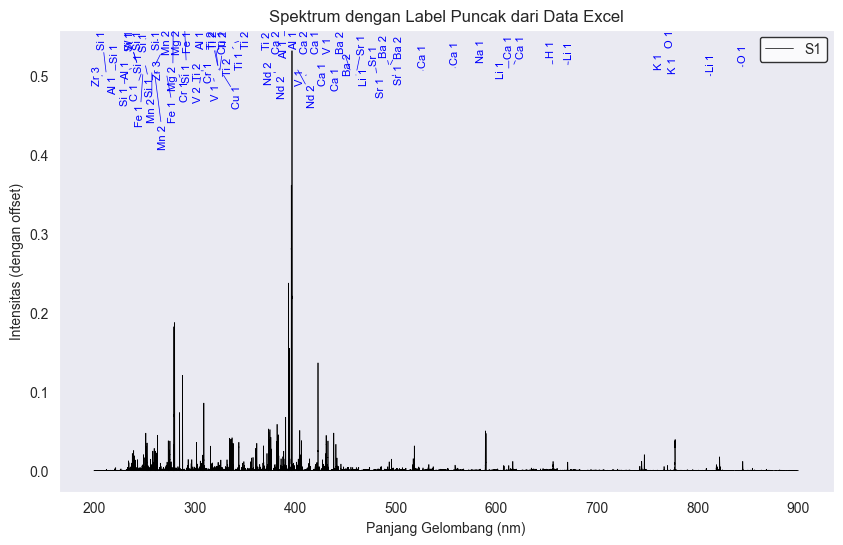

Plot spektrum dengan label telah disimpan dalam format PDF dan PNG.


In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text

# Fungsi untuk mengambil spektrum dari database
def get_processed_spectra(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data untuk sampel: {sample_name}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk plotting spektrum dari database dan menambahkan label puncak dari data Excel
def plot_spectra_with_labels(db_path, sample_names, excel_file, output_pdf='spectra_with_labels.pdf', lower_bound=None, upper_bound=None):
    # Load data dari Excel
    peak_data = pd.read_excel(excel_file)

    # Pengaturan tampilan plot
    plt.figure(figsize=(10, 6), facecolor='white')
    offset = 1  # Offset untuk membedakan intensitas setiap spektrum pada sumbu y
    texts = []  # List untuk menyimpan label teks

    for i, sample_name in enumerate(sample_names):
        wavelengths, intensities = get_processed_spectra(db_path, sample_name, lower_bound, upper_bound)

        # Jika data ditemukan, plot spektrum
        if len(wavelengths) > 0:
            plt.plot(wavelengths, intensities + i * offset, color='black', linewidth=0.5, label=f'{sample_name}')
            
            # Menambahkan label pada puncak dari file Excel
            for _, row in peak_data.iterrows():
                peak_wavelength = row['Panjang Gelombang (nm)']
                element = row['Unsur']
                sp_num = row['sp_num']
                
                # Cari indeks puncak terdekat dalam spektrum
                closest_idx = (np.abs(wavelengths - peak_wavelength)).argmin()
                if np.abs(wavelengths[closest_idx] - peak_wavelength) < 0.1:
                    # Tambahkan teks pada titik puncak
                    text = plt.text(
                        wavelengths[closest_idx], 
                        intensities[closest_idx] + i * offset + 0.5,  # Offset sedikit di atas puncak
                        f'{element} {sp_num}', 
                        fontsize=8, ha='center', va='bottom', rotation=90, color='blue'
                    )
                    texts.append(text)

    # Penyesuaian label teks agar tidak saling tumpang tindih
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='blue', lw=0.5))

    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas (dengan offset)')
    plt.title('Spektrum dengan Label Puncak dari Data Excel')
    plt.legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')
    plt.grid(False)

    # Simpan plot ke file PDF dan PNG
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.savefig(output_pdf.replace('.pdf', '.png'), format='png', bbox_inches='tight', dpi=300)

    plt.show()

# Path ke database dan file Excel
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 2)]
excel_file = 'a2.xlsx'

# Batas panjang gelombang
lower_bound = 200
upper_bound = 900

# Plot dan simpan spektrum dengan label puncak sesuai data Excel
plot_spectra_with_labels(db_path, sample_names, excel_file, 'spectra_with_labels.pdf', lower_bound, upper_bound)

print("Plot spektrum dengan label telah disimpan dalam format PDF dan PNG.")

PROSES 3

In [9]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth, location, dan location_point
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan location_point
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_all_depths_location_points(db_path, sample_names, output_pdf='processed_spectra_all_depths_location_points.pdf', lower_bound=None, upper_bound=None):
    # Daftar depth dan location_point yang akan di-plot
    depths = ['0-20', '20-40', '40-60']
    location_points = ['A', 'B']
    
    with PdfPages(output_pdf) as pdf:
        for location_point in location_points:
            for depth in depths:
                plt.figure(figsize=(10, 6))
                offset = 1  # Offset tetap untuk setiap spektrum pada sumbu y
                plot_counter = 0  # Counter untuk menentukan berapa banyak spektrum yang sudah diplot
                
                for sample_name in sample_names:
                    wavelengths, intensities, sample_depth, location, sample_location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)

                    # Filter berdasarkan location_point dan depth
                    if sample_location_point == location_point and sample_depth == depth and len(wavelengths) > 0:
                        # Menambahkan depth, location, dan location_point ke label pada plot
                        plt.plot(wavelengths, intensities + plot_counter * offset, label=f'{sample_name} (Depth: {depth}, Location: {location}, Location Point: {location_point}, y offset {plot_counter * offset})', linewidth=0.4)
                        plot_counter += 1  # Increment plot counter untuk offset berikutnya

                plt.xlabel('Wavelength (nm)')
                plt.ylabel('Intensity (with y offset)')
                plt.title(f'Processed Spectra with Depth {depth}, Location Point {location_point}')

                # Atur sumbu Y konsisten dari 0 hingga 4
                plt.ylim(0, 4)

                # Meletakkan legenda di luar kotak plot
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

                plt.grid(True)

                # Menyimpan halaman ke dalam file PDF
                pdf.savefig(bbox_inches='tight')

                # Menutup halaman saat ini
                plt.close()

# Path ke database baru
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]  # Semua sampel

# Menentukan batas panjang gelombang
lower_bound = 396  # Contoh: batas bawah panjang gelombang
upper_bound = 398  # Contoh: batas atas panjang gelombang

# Memproses dan menyimpan spektrum untuk seluruh depth dan location_point ke file PDF
plot_and_save_all_depths_location_points(db_path, sample_names, 'processed_spectra_all_depths_location_points.pdf', lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam satu file PDF dengan seluruh kombinasi depth dan location_point.")

Plot spektrum yang diproses telah disimpan dalam satu file PDF dengan seluruh kombinasi depth dan location_point.


In [7]:
import sqlite3
import numpy as np
import pandas as pd

# Fungsi untuk mengambil spektrum yang telah diproses dari database
def get_processed_spectra(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No processed data found for sample: {sample_name}")
        return np.array([]), np.array([])
    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk mengakses spektrum dari semua sampel dan menyimpannya ke dalam Excel
def export_spectra_to_excel(db_path, sample_names, output_excel):
    all_data = {}  # Dictionary untuk menyimpan semua spektrum
    
    for sample_name in sample_names:
        wavelengths, intensities = get_processed_spectra(db_path, sample_name)
        if len(wavelengths) > 0:
            # Simpan spektrum dalam dictionary, dengan kunci sample_name
            all_data[sample_name] = intensities

    # Membuat DataFrame untuk diekspor ke Excel
    df = pd.DataFrame({
        'Wavelength': wavelengths  # Panjang gelombang hanya sekali
    })

    # Tambahkan setiap sampel ke DataFrame sebagai kolom
    for sample_name in sample_names:
        df[sample_name] = all_data.get(sample_name, np.nan)  # Mengisi NaN jika spektrum tidak ada

    # Ekspor ke file Excel
    df.to_excel(output_excel, index=False)
    print(f"Data berhasil diekspor ke {output_excel}")

# Path ke database baru dan nama file output Excel
db_path = 'processed_spectra.db'
output_excel = 'processed_spectra_export.xlsx'
sample_names = [f'S{i}' for i in range(1, 25)]  # 24 sampel

# Ekspor data ke Excel
export_spectra_to_excel(db_path, sample_names, output_excel)

Data berhasil diekspor ke processed_spectra_export.xlsx


proses 4

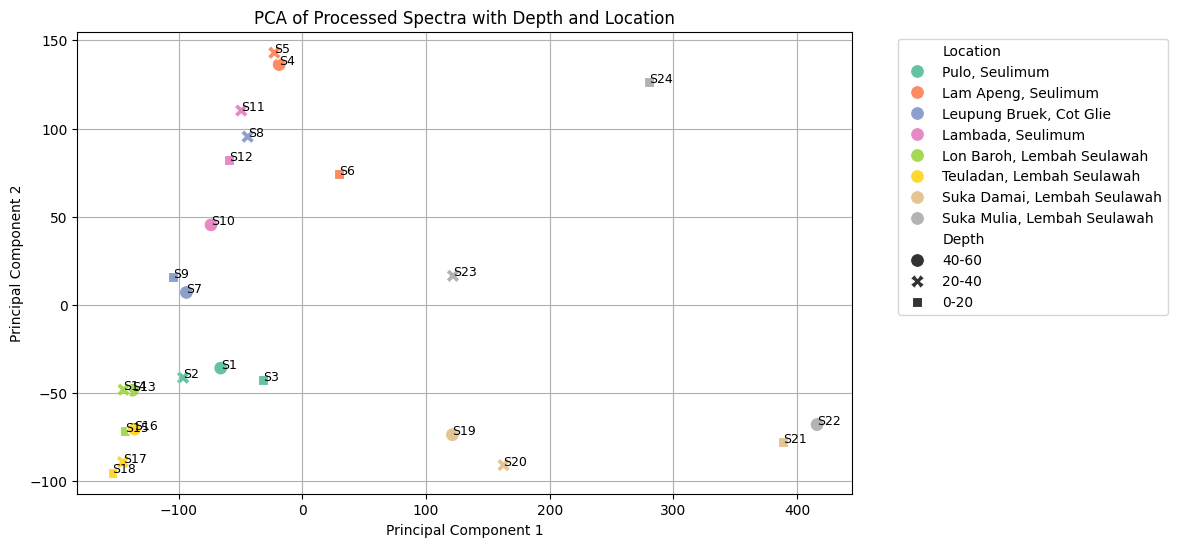

Plot PCA dengan depth dan location telah disimpan dalam bentuk PDF.


In [30]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth dan location
def get_all_spectra_with_metadata(db_path, sample_names):
    all_spectra = []
    metadata = []
    
    for sample_name in sample_names:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        query = """
            SELECT wavelength, intensity, depth, location
            FROM processed_spectrum
            WHERE sample_name = ?
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name,))
        data = cursor.fetchall()
        conn.close()

        if data:
            wavelengths, intensities, depth, location = zip(*data)
            all_spectra.append(np.array(intensities))  # Simpan hanya intensitas
            metadata.append((depth[0], location[0]))   # Simpan depth dan location
        else:
            print(f"No processed data found for sample: {sample_name}")
            all_spectra.append(np.array([]))
            metadata.append((None, None))  # Menambahkan placeholder jika tidak ada data

    return np.array(all_spectra), metadata

# Fungsi untuk melakukan PCA dan plot hasilnya dengan bentuk dan warna sesuai depth dan location
def perform_pca_and_plot(db_path, sample_names, output_pdf='pca_plot_with_depth_location.pdf'):
    # Mengambil spektrum dan metadata dari semua sampel
    spectra, metadata = get_all_spectra_with_metadata(db_path, sample_names)
    
    # Menghapus spektrum yang kosong (jika ada)
    non_empty_spectra = [spec for spec in spectra if spec.size > 0]
    sample_names_filtered = [sample_names[i] for i in range(len(spectra)) if spectra[i].size > 0]
    metadata_filtered = [metadata[i] for i in range(len(spectra)) if spectra[i].size > 0]
    
    # Standarisasi data spektrum (mean = 0, variance = 1)
    scaler = StandardScaler()
    spectra_scaled = scaler.fit_transform(non_empty_spectra)

    # Melakukan PCA
    pca = PCA(n_components=2)  # Mengambil 2 komponen utama pertama
    principal_components = pca.fit_transform(spectra_scaled)

    # Membuat DataFrame untuk memvisualisasikan hasil PCA
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Sample'] = sample_names_filtered
    pca_df['Depth'] = [meta[0] for meta in metadata_filtered]
    pca_df['Location'] = [meta[1] for meta in metadata_filtered]

    # Plot hasil PCA dengan seaborn, menggunakan warna berdasarkan lokasi dan bentuk berdasarkan kedalaman
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Location', style='Depth', palette='Set2', s=100)

    for i, sample_name in enumerate(pca_df['Sample']):
        plt.text(pca_df['PC1'][i], pca_df['PC2'][i], sample_name, fontsize=9)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Processed Spectra with Depth and Location')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Letakkan legend di luar plot

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight', dpi=300)

    # Menampilkan plot
    plt.show()

# Path ke database baru dan daftar nama sampel
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]  # 24 sampel

# Melakukan PCA dan plot hasilnya serta menyimpan ke dalam PDF
perform_pca_and_plot(db_path, sample_names, 'pca_plot_with_depth_location.pdf')

print("Plot PCA dengan depth dan location telah disimpan dalam bentuk PDF.")

In [9]:
import sqlite3

# Fungsi untuk menampilkan nama kolom dari tabel tertentu
def get_table_headers(db_path, table_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mendapatkan informasi kolom dari tabel tertentu
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    conn.close()

    # Cek apakah ada kolom yang ditemukan
    if not columns:
        print(f"Tidak ada kolom ditemukan di tabel: {table_name}")
    else:
        print(f"Nama kolom di tabel '{table_name}':")
        for column in columns:
            print(column[1])  # Kolom [1] adalah nama kolom

# Path ke database
db_path = 'data1.db'
# Nama tabel yang ingin diperiksa kolomnya (gantilah dengan nama tabel yang sesuai)
table_name = 'spectrum_data'  

# Memanggil fungsi untuk mencetak nama kolom dalam tabel
get_table_headers(db_path, table_name)

Nama kolom di tabel 'spectrum_data':
element
sp_num
obs_wl_air(nm)
unc_obs_wl
intens
gA(s^-1)
Acc
Ei(cm-1)
Ek(cm-1)
conf_i
term_i
J_i
conf_k
term_k
J_k
g_i
g_k
Type
tp_ref
line_ref
Unnamed: 20


Element    sp_num    
--------------------
10B        1         
10B        2         
11B        1         
11B        2         
12C        1         
13C        1         
198Hg      1         
Ac         1         
Ac         2         
Ac         3         
Ac         4         
Ag         1         
Ag         2         
Ag         3         
Al         1         
Al         2         
Al         3         
Al         4         
Al         5         
Am         1         
Am         2         
Ar         1         
Ar         2         
Ar         3         
Ar         4         
Ar         5         
Ar         7         
Ar         8         
Ar         9         
Ar         10        
Ar         11        
Ar         13        
Ar         14        
Ar         15        
As         1         
As         2         
As         3         
As         4         
At         1         
Au         1         
Au         2         
Au         3         
B          1         
B          

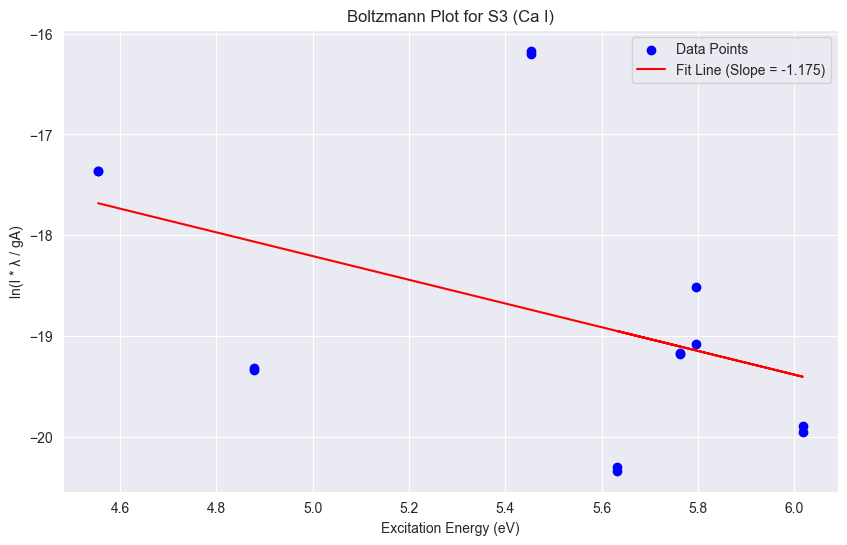

In [19]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # Konstanta hc dalam eV·nm (untuk konversi energi)

# Fungsi untuk mengambil data NIST untuk Ca I saja (kalsium netral)
def get_nist_data_for_ca_i(db_nist):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Query untuk mengambil data Ca I (Ca netral) dari NIST
    query = """
        SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)"
        FROM spectrum_data
        WHERE element = 'Ca' AND sp_num = 1
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print("Tidak ada data NIST ditemukan untuk Ca I (kalsium netral).")
        return []

    # Konversi energi dari cm^-1 ke eV (1 eV = 8065.544 cm^-1)
    nist_data = []
    for wl, Ek, Jk, gA in data:
        try:
            if wl and Ek and Jk and gA:  # Pastikan tidak ada nilai kosong
                wl = float(wl)
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                Jk = float(Jk)
                gA = float(gA)
                nist_data.append((wl, Ek, Jk, gA))
        except ValueError:
            # Lewatkan entri jika ada masalah konversi
            continue
    
    return nist_data

# Fungsi untuk mengambil spektrum yang diproses dari database processed_spectrum dengan metadata
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None

    wavelengths, intensities, depth, location = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0]

# Fungsi untuk mencocokkan data panjang gelombang NIST dengan spektrum yang diproses
def match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance=0.0005):
    matched_data = []
    
    for wl_exp, intensity_exp in zip(processed_wavelengths, processed_intensities):
        for wl_nist, Ek, Jk, gA in nist_data:
            # Pastikan panjang gelombang eksperimen cocok dengan NIST dalam toleransi yang lebih ketat
            if abs(wl_exp - wl_nist) <= tolerance:
                matched_data.append((wl_nist, intensity_exp, Ek, Jk, gA))
                break  # Jika cocok, hentikan pencarian lebih lanjut untuk panjang gelombang ini

    return matched_data

# Fungsi untuk mencetak elemen dan sp_num dari database NIST
def print_element_and_sp_num(db_nist):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    query = """
        SELECT DISTINCT element, sp_num
        FROM spectrum_data
        ORDER BY element, sp_num
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()

    if data:
        print(f"{'Element':<10} {'sp_num':<10}")
        print("-" * 20)
        for element, sp_num in data:
            print(f"{element:<10} {sp_num:<10}")
    else:
        print("Tidak ada data elemen yang ditemukan.")

# Fungsi untuk membuat plot Boltzmann, menghitung suhu plasma, dan mencetak data yang digunakan
def boltzmann_plot(db_processed, db_nist, sample_name, output_pdf='boltzmann_plot.pdf', tolerance=0.0005):
    # Ambil data NIST dan spektrum yang diproses dari database processed_spectrum
    nist_data = get_nist_data_for_ca_i(db_nist)  # Hanya mengambil data Ca I
    processed_wavelengths, processed_intensities, depth, location = get_processed_spectra_with_metadata(db_processed, sample_name)

    if not nist_data or len(processed_wavelengths) == 0:
        return  # Jika tidak ada data, hentikan eksekusi

    # Cocokkan data NIST dengan spektrum yang diproses menggunakan toleransi lebih ketat
    matched_data = match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance)

    if len(matched_data) == 0:
        print("Tidak ada puncak spektrum yang cocok dengan data NIST.")
        return

    # Print data yang digunakan untuk perhitungan
    print("Data yang digunakan (Ca I saja):")
    print(f"{'Wavelength (nm)':<15} {'Intensity':<12} {'Excitation Energy (eV)':<25} {'Degeneracy (J_k)':<20} {'Aki (s^-1)':<10}")
    print("-" * 90)
    for wl, intensity, Ek, Jk, Aki in matched_data:
        print(f"{wl:<15.4f} {intensity:<12.8f} {Ek:<25.4f} {Jk:<20.4f} {Aki:<10.2e}")

    # Siapkan data untuk plot Boltzmann: ln(I * λ / (g * A)) vs Ek
    wavelengths, intensities, energies, degeneracies, aki_values = zip(*matched_data)
    boltzmann_values = np.log((np.array(intensities) * np.array(wavelengths)) / (np.array(degeneracies) * np.array(aki_values)))

    # Buat plot Boltzmann (ln(I * λ / gA) vs Ek)
    plt.figure(figsize=(10, 6))
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    
    # Lakukan fit linear
    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)

    # Plot garis fit linear
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')

    # Hitung suhu plasma dari kemiringan (slope) plot Boltzmann
    T_plasma = -1 / (k_B * slope)
    print(f"Suhu plasma dari plot Boltzmann: {T_plasma:.2f} K")

    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name} (Ca I)')
    plt.legend()
    plt.grid(True)

    # Simpan plot ke file PDF
    plt.savefig(output_pdf, format='pdf')

    # Tampilkan plot
    plt.show()

# Path ke database processed_spectrum dan NIST (data1.db)
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'

# Cetak tabel elemen dan sp_num
print_element_and_sp_num(db_nist)

# Nama sampel yang ingin diproses (misalnya S3)
sample_name = 'S3'

# Panggil fungsi untuk membuat plot Boltzmann dan menghitung suhu plasma
boltzmann_plot(db_processed, db_nist, sample_name, output_pdf='boltzmann_plot_S3.pdf')

Data yang digunakan (Ca 1):
Wavelength (nm) Intensity    Excitation Energy (eV)    Degeneracy (J_k)     Aki (s^-1)
------------------------------------------------------------------------------------------
215.0800        0.00039261   5.76276231                1.00000000           1.80e+07  
215.0800        0.00039640   5.76276231                1.00000000           1.80e+07  
220.0730        0.00031982   5.63202656                1.00000000           4.59e+07  
220.0730        0.00030756   5.63202656                1.00000000           4.59e+07  
299.4960        0.00079830   6.01789823                1.00000000           1.10e+08  
299.4960        0.00084300   6.01789823                1.00000000           1.10e+08  
318.0520        0.00014202   5.79604835                1.00000000           8.70e+06  
318.0520        0.00024903   5.79604835                1.00000000           8.70e+06  
347.4760        0.00382642   5.45292010                1.00000000           1.40e+07  
347.4760   

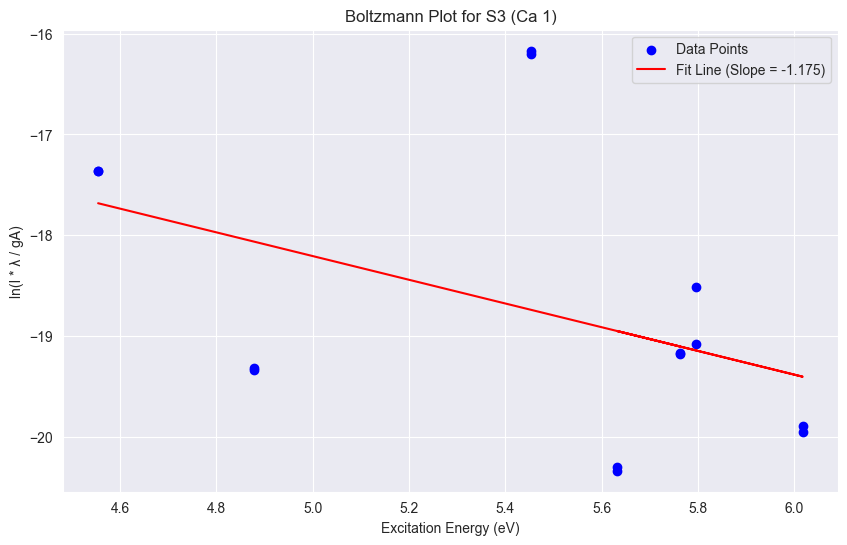

In [2]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # Konstanta hc dalam eV·nm (untuk konversi energi)

# Fungsi untuk mengambil data NIST berdasarkan elemen dan tingkat ionisasi (sp_num)
def get_nist_data_for_element(db_nist, element, ionization_stage):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Query untuk mengambil data NIST berdasarkan elemen dan tingkat ionisasi
    query = """
        SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, ionization_stage))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data NIST ditemukan untuk {element} {ionization_stage}.")
        return []

    # Konversi energi dari cm^-1 ke eV (1 eV = 8065.544 cm^-1)
    nist_data = []
    for wl, Ek, Jk, gA in data:
        try:
            if wl and Ek and Jk and gA:  # Pastikan tidak ada nilai kosong
                wl = float(wl)
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                Jk = float(Jk)
                gA = float(gA)
                nist_data.append((wl, Ek, Jk, gA))
        except ValueError:
            continue  # Lewatkan entri jika ada masalah konversi
    
    return nist_data

# Fungsi untuk mengambil spektrum yang diproses dari database processed_spectrum dengan metadata
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None

    wavelengths, intensities, depth, location = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0]

# Fungsi untuk mencocokkan data panjang gelombang NIST dengan spektrum yang diproses
def match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance=0.0005):
    matched_data = []
    
    for wl_exp, intensity_exp in zip(processed_wavelengths, processed_intensities):
        for wl_nist, Ek, Jk, gA in nist_data:
            # Pastikan panjang gelombang eksperimen cocok dengan NIST dalam toleransi yang lebih ketat
            if abs(wl_exp - wl_nist) <= tolerance:
                matched_data.append((wl_nist, intensity_exp, Ek, Jk, gA))
                break  # Jika cocok, hentikan pencarian lebih lanjut untuk panjang gelombang ini

    return matched_data

# Fungsi untuk membuat plot Boltzmann, menghitung suhu plasma, dan mencetak data yang digunakan
def boltzmann_plot(db_processed, db_nist, sample_name, element, ionization_stage, output_pdf='boltzmann_plot.pdf', tolerance=0.0005):
    # Ambil data NIST untuk elemen dan tingkat ionisasi yang diinginkan
    nist_data = get_nist_data_for_element(db_nist, element, ionization_stage)
    processed_wavelengths, processed_intensities, depth, location = get_processed_spectra_with_metadata(db_processed, sample_name)

    if not nist_data or len(processed_wavelengths) == 0:
        return  # Jika tidak ada data, hentikan eksekusi

    # Cocokkan data NIST dengan spektrum yang diproses menggunakan toleransi lebih ketat
    matched_data = match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance)

    if len(matched_data) == 0:
        print(f"Tidak ada puncak spektrum yang cocok dengan data NIST untuk {element} {ionization_stage}.")
        return

    # Print data yang digunakan untuk perhitungan
    print(f"Data yang digunakan ({element} {ionization_stage}):")
    print(f"{'Wavelength (nm)':<15} {'Intensity':<12} {'Excitation Energy (eV)':<25} {'Degeneracy (J_k)':<20} {'Aki (s^-1)':<10}")
    print("-" * 90)
    for wl, intensity, Ek, Jk, Aki in matched_data:
        print(f"{wl:<15.4f} {intensity:<12.8f} {Ek:<25.8f} {Jk:<20.8f} {Aki:<10.2e}")

    # Siapkan data untuk plot Boltzmann: ln(I * λ / (g * A)) vs Ek
    wavelengths, intensities, energies, degeneracies, aki_values = zip(*matched_data)
    boltzmann_values = np.log((np.array(intensities) * np.array(wavelengths)) / (np.array(degeneracies) * np.array(aki_values)))

    # Buat plot Boltzmann (ln(I * λ / gA) vs Ek)
    plt.figure(figsize=(10, 6))
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    
    # Lakukan fit linear
    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)

    # Plot garis fit linear
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')

    # Hitung suhu plasma dari kemiringan (slope) plot Boltzmann
    T_plasma = -1 / (k_B * slope)
    print(f"Suhu plasma dari plot Boltzmann: {T_plasma:.2f} K")

    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name} ({element} {ionization_stage})')
    plt.legend()
    plt.grid(True)

    # Simpan plot ke file PDF
    plt.savefig(output_pdf, format='pdf')

    # Tampilkan plot
    plt.show()

# Path ke database processed_spectrum dan NIST (data1.db)
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'

# Nama sampel yang ingin diproses (misalnya S3)
sample_name = 'S3'

# Pilih elemen dan tingkat ionisasi yang diinginkan
element = ('Ca')  # Misalnya untuk Kalsium (Ca)
ionization_stage = 1# 1 untuk Ca I (netral), 2 untuk Ca II (ion pertama)

# Panggil fungsi untuk membuat plot Boltzmann dan menghitung suhu plasma
boltzmann_plot(db_processed, db_nist, sample_name, element, ionization_stage, output_pdf=f'boltzmann_plot_{element}_{ionization_stage}.pdf')

In [44]:
import numpy as np

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # hc dalam eV·nm
m_e = 9.10938356e-31  # Massa elektron dalam kg
h = 6.62607015e-34  # Konstanta Planck dalam Js

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    # Persamaan Saha untuk menghitung rasio N_ion / N_neutral
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

def calculate_total_concentration_with_ionization(T_e, n_e, elements_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0

    for element, lines_data in elements_data.items():
        Z_neutral = 0  # Fungsi partisi untuk atom netral
        neutral_concentration = 0

        # Hitung fungsi partisi Z(T_e) dan populasi untuk atom netral
        for intensity, wl, E_u, gAki in lines_data:
            if E_u > 50:  # Konversi energi ke eV jika diperlukan
                E_u = E_u / 8065.544

            Z_neutral += np.exp(-E_u / (k_B * T_e))
            N_rel = (intensity * wl) / (gAki * np.exp(-E_u / (k_B * T_e)))
            neutral_concentration += N_rel

        # Jika data ionisasi tersedia, hitung rasio ionisasi menggunakan persamaan Saha
        if element in ionization_data:
            Z_ion_data, E_ionization = ionization_data[element]
            Z_ion = sum(np.exp(-E_u / (k_B * T_e)) for _, _, E_u, _ in Z_ion_data)
            
            # Rasio ionisasi berdasarkan persamaan Saha
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            
            # Tambahkan konsentrasi ion terionisasi ke total konsentrasi
            ion_concentration = ionization_ratio * neutral_concentration
            total_concentration = neutral_concentration + ion_concentration
            
            # Tandai ionisasi dengan "I" dan "II" untuk level netral dan terionisasi
            total_concentrations[f"{element} I"] = neutral_concentration
            total_concentrations[f"{element} II"] = ion_concentration
        else:
            total_concentrations[f"{element} I"] = neutral_concentration
            total_concentration = neutral_concentration

        overall_concentration += total_concentration

    # Normalisasi ke dalam persentase
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100

    # Gabungkan konsentrasi untuk atom netral dan terionisasi
    final_concentrations = {}
    for element_label, concentration in total_concentrations.items():
        element_base = element_label.split()[0]
        if element_base in final_concentrations:
            final_concentrations[element_base] += concentration
        else:
            final_concentrations[element_base] = concentration

    return final_concentrations

# Data spektral contoh dengan nilai gAki
elements_data = {
    'Ca': [
        (0.00039261, 215.0800, 5.7628, 1.80e7),
        (0.00031982, 220.0730, 5.6320, 4.59e7),
        (0.00079830, 299.4960, 6.0179, 1.10e8)
    ],
    'Fe': [
        (0.00123958, 380.193, 5.1289, 2.70e8),
        (0.00238401, 381.584, 5.2458, 1.60e8),
    ],
    'Mg': [
        (0.0003125, 285.213, 4.3456, 1.90e8),
        (0.0005120, 383.826, 4.6523, 1.22e8),
    ],
    'Al': [
        (0.0005120, 309.271, 4.6720, 2.32e8),
        (0.0006123, 394.422, 4.7213, 1.87e8),
    ]
}

# Data ionisasi untuk setiap unsur
ionization_data = {
    'Ca': (
        [
            (0.00129, 393.366, 7.5180, 1.65e8),
            (0.0008, 396.847, 7.6860, 1.20e8)
        ],
        6.1132  # Energi ionisasi untuk Ca I dalam eV
    ),
    'Fe': (
        [
            (0.0027, 238.204, 6.0470, 5.98e7),
            (0.0015, 241.173, 6.2680, 3.65e7)
        ],
        7.9024  # Energi ionisasi untuk Fe I dalam eV
    ),
    'Mg': (
        [
            (0.0015, 285.213, 5.3456, 1.78e7),
            (0.0012, 383.826, 5.6523, 9.34e7)
        ],
        7.6462  # Energi ionisasi untuk Mg I dalam eV
    ),
    'Al': (
        [
            (0.0009, 309.271, 5.7120, 2.32e8),
            (0.0007, 394.422, 5.7313, 1.45e8)
        ],
        5.9858  # Energi ionisasi untuk Al I dalam eV
    )
}

# Suhu elektron (Te) dan densitas elektron (Ne)
T_e = 8000  # Kelvin
n_e = 1e17  # cm^-3

# Hitung konsentrasi total dengan ionisasi
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, elements_data, ionization_data)

# Print hasil konsentrasi akhir
print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Konsentrasi total unsur dalam sampel (dalam persen):
Ca: 70.06%
Fe: 9.95%
Mg: 1.55%
Al: 18.45%


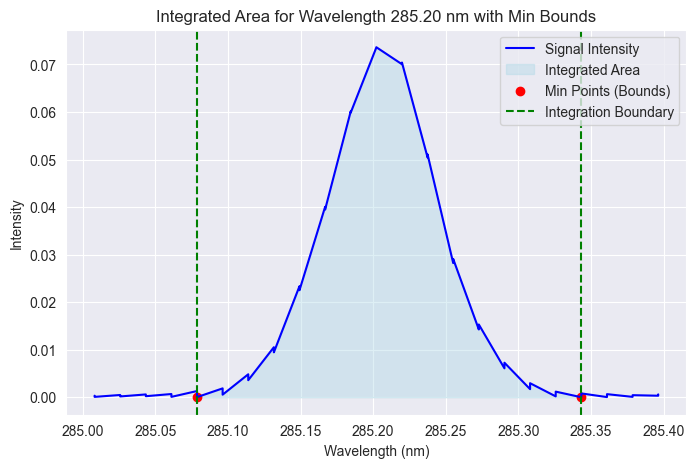

Suhu plasma: 11957.54 K

Experimental Wavelength (nm) Integrated Intensity Excitation Energy (eV)    gA (s^-1) 
--------------------------------------------------------------------------------
285.2022                  0.00680573           4.34580284                1.47e+09  
383.7327                  0.00152172           5.94591574                1.13e+09  
517.2684                  0.00245345           5.10782695                1.01e+08  
277.9663                  0.00031524           7.17042769                4.08e+08  


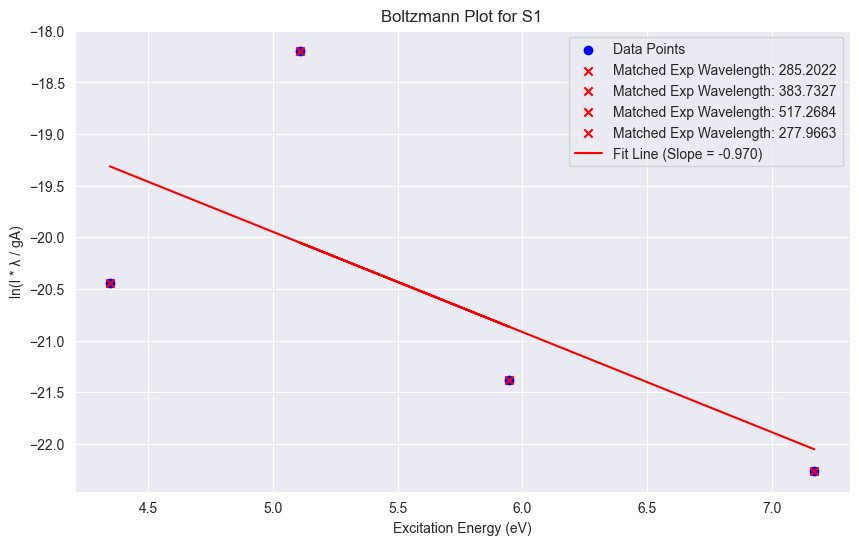

In [42]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import find_peaks

k_B = 8.617333262145e-5
hc_in_eVnm = 1239.841984

def get_nist_data_for_wavelengths(db_nist, nist_wavelengths):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    nist_data = []
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        if result:
            obs_wl, Ek, gA = result
            try:
                Ek = float(Ek) / 8065.544  # Konversi ke eV jika valid
                nist_data.append((obs_wl, Ek, float(gA)))
            except ValueError:
                print(f"Skipping invalid Ek value for wavelength {obs_wl}")
    conn.close()
    return nist_data

def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths, plot_example=False):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for i, wl_exp in enumerate(exp_wavelengths):
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            peak_index, _ = find_peaks(intensities, height=max(intensities) * 0.5)
            if len(peak_index) == 0:
                integrated_intensities.append(None)
                continue

            peak_index = peak_index[0]
            left_min_index = np.argmin(intensities[:peak_index])
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)

            if plot_example and i == 0:
                plt.figure(figsize=(8, 5))
                plt.plot(wavelengths, intensities, label="Signal Intensity", color="blue")
                plt.fill_between(wavelengths[left_min_index:right_min_index + 1], intensities[left_min_index:right_min_index + 1], color="lightblue", alpha=0.4, label="Integrated Area")
                plt.scatter([wavelengths[left_min_index], wavelengths[right_min_index]], 
                            [intensities[left_min_index], intensities[right_min_index]], color="red", label="Min Points (Bounds)")
                plt.axvline(x=wavelengths[left_min_index], color="green", linestyle="--", label="Integration Boundary")
                plt.axvline(x=wavelengths[right_min_index], color="green", linestyle="--")
                plt.xlabel("Wavelength (nm)")
                plt.ylabel("Intensity")
                plt.title(f"Integrated Area for Wavelength {wl_exp:.2f} nm with Min Bounds")
                plt.legend()
                plt.show()
        else:
            integrated_intensities.append(None)
    conn.close()
    return integrated_intensities

def calculate_temperature(nist_data, intensities, exp_wavelengths):
    energies = []
    boltzmann_values = []
    matched_indices = []

    for i, (wl_nist, Ek, gA) in enumerate(nist_data):
        intensity = intensities[i]
        if intensity is None or gA == 0:
            continue

        boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
        energies.append(Ek)
        boltzmann_values.append(boltzmann_value)
        matched_indices.append(i)

    if len(boltzmann_values) < 2:
        print("Tidak cukup data untuk menghitung suhu plasma.")
        return None, None, None, matched_indices

    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)
    T_plasma = -1 / (k_B * slope)
    return T_plasma, energies, boltzmann_values, matched_indices

def boltzmann_temperature_from_experimental(db_processed, db_nist, sample_name, nist_wavelengths, exp_wavelengths):
    nist_data = get_nist_data_for_wavelengths(db_nist, nist_wavelengths)
    intensities = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths, plot_example=True)
    T_plasma, energies, boltzmann_values, matched_indices = calculate_temperature(nist_data, intensities, exp_wavelengths)

    if T_plasma:
        print(f"Suhu plasma: {T_plasma:.2f} K")
    else:
        print("Gagal menghitung suhu plasma.")
        return

    print(f"\n{'Experimental Wavelength (nm)':<25} {'Integrated Intensity':<20} {'Excitation Energy (eV)':<25} {'gA (s^-1)':<10}")
    print("-" * 80)
    for i, (wl_nist, Ek, gA) in enumerate(nist_data):
        intensity = intensities[i]
        wl_exp = exp_wavelengths[i]
        try:
            wl_exp = f"{float(wl_exp):.4f}"
            intensity = f"{float(intensity):.8f}" if intensity is not None else "N/A"
            Ek = f"{float(Ek):.8f}"
            gA = f"{float(gA):.2e}"
        except ValueError:
            wl_exp, intensity, Ek, gA = "N/A", "N/A", "N/A", "N/A"
        print(f"{wl_exp:<25} {intensity:<20} {Ek:<25} {gA:<10}")

    plt.figure(figsize=(10, 6))
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    for idx in matched_indices:
        if idx < len(energies):
            plt.scatter(energies[idx], boltzmann_values[idx], color='red', marker='x', label=f'Matched Exp Wavelength: {exp_wavelengths[idx]:.4f}')

    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')
    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig('boltzmann_plot_experimental.pdf', format='pdf')
    plt.show()

# Panjang gelombang NIST dan Eksperimental untuk Mg I
#nist_wavelengths = [285.2127, 383.82918, 517.26843, 277.9831]
#exp_wavelengths = [285.20221, 383.73273, 517.26843, 277.96631]
nist_wavelengths = [285.2127, 383.82918, 517.26843, 277.9831]
exp_wavelengths = [285.20221, 383.73273, 517.26843, 277.96631]
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'
sample_name = 'S1'

boltzmann_temperature_from_experimental(db_processed, db_nist, sample_name, nist_wavelengths, exp_wavelengths)

In [3]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import find_peaks

k_B = 8.617333262145e-5

def get_ek_from_nist(db_nist, nist_wavelength):
    """
    Mengambil nilai Ek dari database NIST berdasarkan panjang gelombang.
    """
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    query = """
        SELECT "Ek(cm-1)"
        FROM spectrum_data
        WHERE "obs_wl_air(nm)" = ?
    """
    cursor.execute(query, (nist_wavelength,))
    result = cursor.fetchone()
    conn.close()
    if result:
        # Konversi Ek dari cm⁻¹ ke eV
        return float(result[0]) / 8065.544
    else:
        return None

def load_data_from_excel(file_path, db_nist, selected_element, selected_ion_stage):
    df = pd.read_excel(file_path)
    required_columns = ["Element", "Ion Stage", "NIST WL", "Exp Peak WL"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")

    # Filter berdasarkan elemen dan tahap ionisasi yang dipilih
    filtered_data = df[(df["Element"] == selected_element) & (df["Ion Stage"] == selected_ion_stage)]
    
    nist_wavelengths = filtered_data["NIST WL"].tolist()
    exp_wavelengths = filtered_data["Exp Peak WL"].tolist()
    
    # Ambil nilai Ek untuk setiap panjang gelombang NIST dari database
    ek_values = [get_ek_from_nist(db_nist, wl) for wl in nist_wavelengths]
    
    # Tampilkan daftar panjang gelombang yang tersedia beserta Ek
    print("\nDaftar panjang gelombang yang tersedia:")
    for i, (nist_wl, exp_wl, ek) in enumerate(zip(nist_wavelengths, exp_wavelengths, ek_values)):
        ek_display = f"{ek:.4f} eV" if ek is not None else "N/A"
        print(f"{i + 1}. NIST WL: {nist_wl} nm, Exp WL: {exp_wl} nm, Ek: {ek_display}")
    
    # Pilih panjang gelombang yang diinginkan
    selected_indices = input("Masukkan nomor panjang gelombang yang ingin dipakai (pisahkan dengan koma, contoh: 1,3,5): ")
    selected_indices = [int(idx.strip()) - 1 for idx in selected_indices.split(",")]

    # Filter data berdasarkan pilihan
    selected_nist_wavelengths = [nist_wavelengths[i] for i in selected_indices]
    selected_exp_wavelengths = [exp_wavelengths[i] for i in selected_indices]
    
    return selected_nist_wavelengths, selected_exp_wavelengths

def get_nist_data_for_wavelengths(db_nist, nist_wavelengths):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    nist_data = []
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        if result:
            obs_wl, Ek, gA = result
            try:
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                nist_data.append((obs_wl, Ek, float(gA)))
            except ValueError:
                print(f"Skipping invalid Ek value for wavelength {obs_wl}")
    conn.close()
    return nist_data
def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths, plot_example=False):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for i, wl_exp in enumerate(exp_wavelengths):
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            peak_index, _ = find_peaks(intensities, height=max(intensities) * 0.5)
            if len(peak_index) == 0:
                integrated_intensities.append(None)
                continue

            peak_index = peak_index[0]
            left_min_index = np.argmin(intensities[:peak_index])
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)

            if plot_example and i == 0:
                plt.figure(figsize=(8, 5))
                plt.plot(wavelengths, intensities, label="Signal Intensity", color="blue")
                plt.fill_between(wavelengths[left_min_index:right_min_index + 1], intensities[left_min_index:right_min_index + 1], color="lightblue", alpha=0.4, label="Integrated Area")
                plt.scatter([wavelengths[left_min_index], wavelengths[right_min_index]], 
                            [intensities[left_min_index], intensities[right_min_index]], color="red", label="Min Points (Bounds)")
                plt.axvline(x=wavelengths[left_min_index], color="green", linestyle="--", label="Integration Boundary")
                plt.axvline(x=wavelengths[right_min_index], color="green", linestyle="--")
                plt.xlabel("Wavelength (nm)")
                plt.ylabel("Intensity")
                plt.title(f"Integrated Area for Wavelength {wl_exp:.2f} nm with Min Bounds")
                plt.legend()
                plt.show()
        else:
            integrated_intensities.append(None)
    conn.close()
    return integrated_intensities

def calculate_temperature(nist_data, intensities, exp_wavelengths):
    energies = []
    boltzmann_values = []

    for i, (wl_nist, Ek, gA) in enumerate(nist_data):
        intensity = intensities[i]
        if intensity is None or gA == 0:
            continue

        boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
        energies.append(Ek)
        boltzmann_values.append(boltzmann_value)

    if len(boltzmann_values) < 2:
        print("Tidak cukup data untuk menghitung suhu plasma.")
        return None, None, None

    slope, intercept, _, _, _ = linregress(energies, boltzmann_values)
    T_plasma = -1 / (k_B * slope)
    return T_plasma, energies, boltzmann_values

def boltzmann_temperature_from_experimental(db_processed, db_nist, sample_name, nist_wavelengths, exp_wavelengths):
    nist_data = get_nist_data_for_wavelengths(db_nist, nist_wavelengths)
    intensities = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths, plot_example=True)
    T_plasma, energies, boltzmann_values = calculate_temperature(nist_data, intensities, exp_wavelengths)

    if T_plasma:
        print(f"Suhu plasma: {T_plasma:.2f} K")
    else:
        print("Gagal menghitung suhu plasma.")
        return

    plt.figure(figsize=(10, 6))
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    slope, intercept, _, _, _ = linregress(energies, boltzmann_values)
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')
    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Contoh penggunaan
file_path = 'S1.xlsx'  # Ganti dengan path file Excel Anda
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'
sample_name = 'S1'
selected_element = "Al"  # Ganti dengan elemen yang Anda pilih
selected_ion_stage = 1  # Ganti dengan tahap ion yang Anda pilih

# Load data dari Excel dan pilih panjang gelombang yang akan digunakan
nist_wavelengths, exp_wavelengths = load_data_from_excel(file_path, db_nist, selected_element, selected_ion_stage)

# Hitung suhu plasma
boltzmann_temperature_from_experimental(db_processed, db_nist, sample_name, nist_wavelengths, exp_wavelengths)


Daftar panjang gelombang yang tersedia:
1. NIST WL: 265.2484 nm, Exp WL: 265.23697 nm, Ek: 4.6729 eV
2. NIST WL: 266.0393 nm, Exp WL: 266.03192 nm, Ek: 4.6729 eV
3. NIST WL: 256.7984 nm, Exp WL: 256.80066 nm, Ek: 4.8266 eV
4. NIST WL: 226.3462 nm, Exp WL: 226.3513 nm, Ek: 5.4759 eV
5. NIST WL: 226.9096 nm, Exp WL: 226.90897 nm, Ek: 5.4762 eV
6. NIST WL: 877.2866 nm, Exp WL: 876.98944 nm, Ek: 5.4344 eV
7. NIST WL: 394.40058 nm, Exp WL: 394.39182 nm, Ek: 3.1427 eV
8. NIST WL: 396.152 nm, Exp WL: 396.14883 nm, Ek: N/A
9. NIST WL: 308.21529 nm, Exp WL: 308.22134 nm, Ek: 4.0215 eV
10. NIST WL: 309.27099 nm, Exp WL: 309.26712 nm, Ek: 4.0217 eV
11. NIST WL: 225.7999 nm, Exp WL: 225.82381 nm, Ek: 5.4892 eV
12. NIST WL: 237.207 nm, Exp WL: 237.34903 nm, Ek: N/A
13. NIST WL: 211.8312 nm, Exp WL: 211.78349 nm, Ek: 5.8511 eV
14. NIST WL: 212.9663 nm, Exp WL: 212.8839 nm, Ek: 5.8199 eV
15. NIST WL: 213.4733 nm, Exp WL: 213.54849 nm, Ek: 5.8200 eV
16. NIST WL: 215.0699 nm, Exp WL: 215.10852 nm, Ek:

KeyboardInterrupt: Interrupted by user

2024-11-11 07:25:15.492 Python[21713:1058207] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-11 07:25:15.492 Python[21713:1058207] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2024-11-11 07:25:17.645 Python[21713:1058207] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


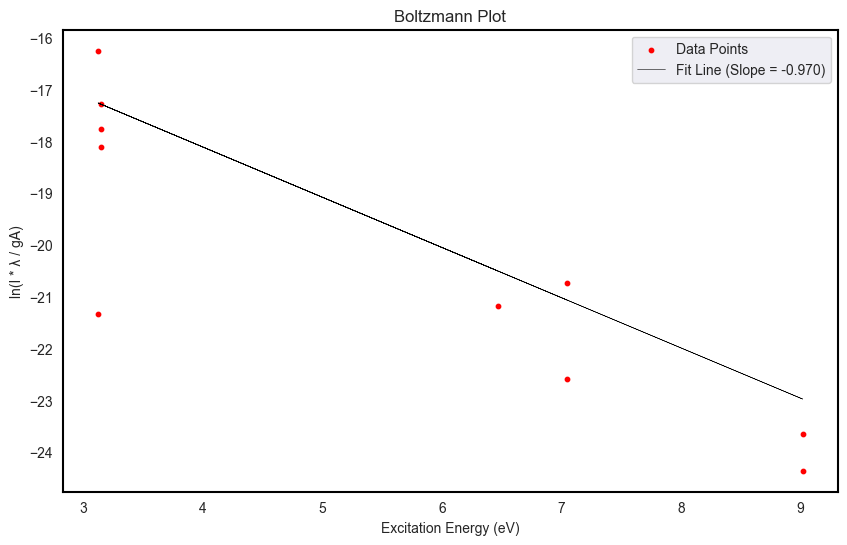

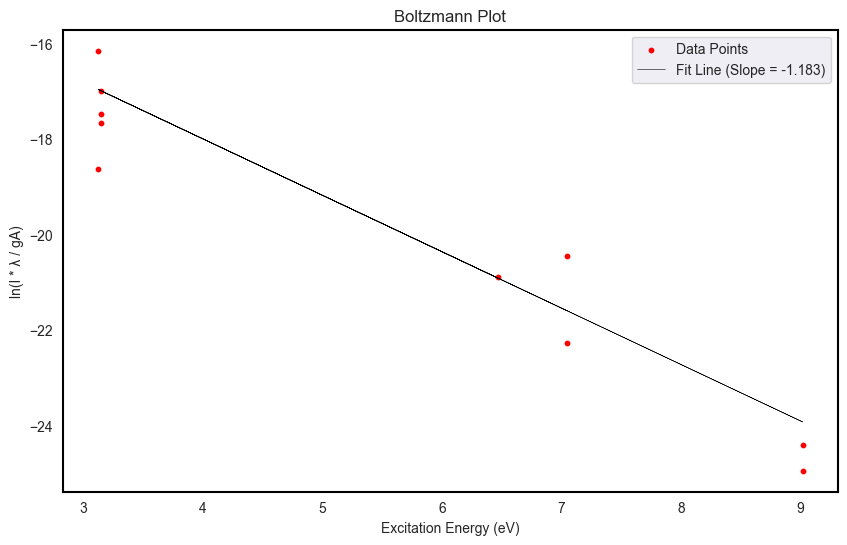

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tkinter import Tk, Button, Label, filedialog, StringVar, OptionMenu, messagebox, ttk, Frame
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import find_peaks

k_B = 8.617333262145e-5

def get_ek_from_nist(db_nist, nist_wavelength):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    query = """
        SELECT "Ek(cm-1)"
        FROM spectrum_data
        WHERE "obs_wl_air(nm)" = ?
    """
    cursor.execute(query, (nist_wavelength,))
    result = cursor.fetchone()
    conn.close()
    if result:
        return float(result[0]) / 8065.544
    else:
        return None

def load_data_from_excel(file_path, db_nist, selected_element, selected_ion_stage):
    df = pd.read_excel(file_path)
    required_columns = ["Element", "Ion Stage", "NIST WL", "Exp Peak WL"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    filtered_data = df[(df["Element"] == selected_element) & (df["Ion Stage"] == selected_ion_stage)]
    nist_wavelengths = filtered_data["NIST WL"].tolist()
    exp_wavelengths = filtered_data["Exp Peak WL"].tolist()
    ek_values = [get_ek_from_nist(db_nist, wl) for wl in nist_wavelengths]
    
    data = []
    for nist_wl, exp_wl, ek in zip(nist_wavelengths, exp_wavelengths, ek_values):
        ek_display = f"{ek:.4f} eV" if ek is not None else "N/A"
        data.append((nist_wl, exp_wl, ek_display))
    return data

def get_nist_data_for_wavelengths(db_nist, nist_wavelengths):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    nist_data = []
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        if result:
            obs_wl, Ek, gA = result
            try:
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                nist_data.append((obs_wl, Ek, float(gA)))
            except ValueError:
                print(f"Skipping invalid Ek value for wavelength {obs_wl}")
    conn.close()
    return nist_data

def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            peak_index, _ = find_peaks(intensities, height=max(intensities) * 0.5)
            if len(peak_index) == 0:
                integrated_intensities.append(None)
                continue

            peak_index = peak_index[0]
            left_min_index = np.argmin(intensities[:peak_index])
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    conn.close()
    return integrated_intensities

def calculate_temperature(nist_data, intensities, exp_wavelengths):
    energies = []
    boltzmann_values = []

    for i, (wl_nist, Ek, gA) in enumerate(nist_data):
        intensity = intensities[i]
        if intensity is None or gA == 0:
            continue

        boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
        energies.append(Ek)
        boltzmann_values.append(boltzmann_value)

    if len(boltzmann_values) < 2:
        print("Tidak cukup data untuk menghitung suhu plasma.")
        return None, None, None

    slope, intercept, _, _, _ = linregress(energies, boltzmann_values)
    T_plasma = -1 / (k_B * slope)
    return T_plasma, slope, energies, boltzmann_values

class PlasmaTemperatureApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Plasma Temperature Calculator")

        self.db_nist = "data1.db"
        self.db_processed = "processed_spectra.db"
        self.excel_file_path = None
        self.excel_data = None
        self.elements = []
        self.ion_stages = {}
        self.selected_element = StringVar()
        self.selected_ion_stage = StringVar()
        self.selected_sample = StringVar()
        self.selected_lines = []

        main_frame = Frame(self.root)
        main_frame.pack(padx=10, pady=10, fill="both", expand=True)

        self.setup_ui(main_frame)

    def setup_ui(self, frame):
        input_frame = Frame(frame)
        input_frame.grid(row=0, column=0, padx=10, pady=5, sticky="nw")

        load_button = Button(input_frame, text="Load Excel File", command=self.load_excel_file)
        load_button.grid(row=0, column=0, columnspan=2, pady=5)

        Label(input_frame, text="Select Element:").grid(row=1, column=0, sticky="e")
        self.element_menu = OptionMenu(input_frame, self.selected_element, ())
        self.element_menu.grid(row=1, column=1, sticky="w", pady=5)

        Label(input_frame, text="Select Ion Stage:").grid(row=2, column=0, sticky="e")
        self.ion_stage_menu = OptionMenu(input_frame, self.selected_ion_stage, ())
        self.ion_stage_menu.grid(row=2, column=1, sticky="w", pady=5)

        Label(input_frame, text="Select Sample:").grid(row=3, column=0, sticky="e")
        sample_options = [f"S{i}" for i in range(1, 25)]
        self.selected_sample.set(sample_options[0])  # Default to S1
        sample_menu = OptionMenu(input_frame, self.selected_sample, *sample_options)
        sample_menu.grid(row=3, column=1, sticky="w", pady=5)

        show_table_button = Button(input_frame, text="Show Lines for Selection", command=self.show_line_table)
        show_table_button.grid(row=4, column=0, columnspan=2, pady=10)

        calculate_button = Button(input_frame, text="Calculate Plasma Temperature", command=self.calculate_plasma_temperature)
        calculate_button.grid(row=5, column=0, columnspan=2, pady=10)

        plot_frame = Frame(frame)
        plot_frame.grid(row=0, column=1, rowspan=2, padx=10, pady=5, sticky="ne")
        self.plot_frame = plot_frame
        self.canvas = None

        self.table_frame = Frame(frame)
        self.table_frame.grid(row=1, column=0, padx=10, pady=5, sticky="sw")

        self.result_frame = Frame(frame)
        self.result_frame.grid(row=2, column=0, columnspan=2, padx=10, pady=5, sticky="sw")

    def load_excel_file(self):
        file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
        if file_path:
            try:
                self.excel_file_path = file_path
                df = pd.read_excel(file_path)
                required_columns = ["Element", "Ion Stage", "NIST WL", "Exp Peak WL"]
                if not all(col in df.columns for col in required_columns):
                    raise ValueError("Excel file is missing required columns.")
                self.excel_data = df
                self.update_element_menu()
                messagebox.showinfo("Success", "Excel data loaded successfully.")
            except Exception as e:
                messagebox.showerror("Error", str(e))

    def update_element_menu(self):
        self.elements = self.excel_data["Element"].unique().tolist()
        self.ion_stages = {
            element: self.excel_data[self.excel_data["Element"] == element]["Ion Stage"].unique().tolist()
            for element in self.elements
        }

        self.element_menu["menu"].delete(0, "end")
        for element in self.elements:
            self.element_menu["menu"].add_command(label=element, command=lambda el=element: self.on_element_selected(el))

        if self.elements:
            self.selected_element.set(self.elements[0])
            self.on_element_selected(self.elements[0])

    def on_element_selected(self, element):
        self.selected_element.set(element)
        self.update_ion_stage_menu(element)

    def update_ion_stage_menu(self, element):
        ion_stages = self.ion_stages.get(element, [])
        self.ion_stage_menu["menu"].delete(0, "end")
        
        for ion_stage in ion_stages:
            self.ion_stage_menu["menu"].add_command(label=ion_stage, command=lambda ion=ion_stage: self.selected_ion_stage.set(ion))
        
        if ion_stages:
            self.selected_ion_stage.set(ion_stages[0])

    def show_line_table(self):
        selected_element = self.selected_element.get()
        selected_ion_stage = int(self.selected_ion_stage.get())

        line_data = load_data_from_excel(self.excel_file_path, self.db_nist, selected_element, selected_ion_stage)
        exp_wavelengths = [row[1] for row in line_data]
        integrated_intensities = get_integrated_intensity_with_min_bounds(self.db_processed, self.selected_sample.get(), exp_wavelengths)

        for widget in self.table_frame.winfo_children():
            widget.destroy()

        tree = ttk.Treeview(self.table_frame, columns=("NIST WL", "Exp WL", "Ek (eV)", "Integrated Intensity"), show="headings", selectmode="extended")
        tree.heading("NIST WL", text="NIST WL")
        tree.heading("Exp WL", text="Exp WL")
        tree.heading("Ek (eV)", text="Ek (eV)")
        tree.heading("Integrated Intensity", text="Integrated Intensity")

        for row, intensity in zip(line_data, integrated_intensities):
            tree.insert("", "end", values=(row[0], row[1], row[2], f"{intensity:.2f}" if intensity else "N/A"))
        
        tree.pack(fill="both", expand=True)
        
        select_button = Button(self.table_frame, text="Select Lines", command=lambda: self.select_lines(tree))
        select_button.pack(pady=5)

    def select_lines(self, tree):
        selected_items = tree.selection()
        self.selected_lines = [(tree.item(item)["values"][0], tree.item(item)["values"][1]) for item in selected_items]
        messagebox.showinfo("Selection", f"{len(self.selected_lines)} lines selected for temperature calculation.")

    def calculate_plasma_temperature(self):
        if not self.selected_lines:
            messagebox.showerror("Error", "No lines selected for calculation.")
            return

        nist_wavelengths = [float(line[0]) for line in self.selected_lines]
        exp_wavelengths = [float(line[1]) for line in self.selected_lines]

        intensities = get_integrated_intensity_with_min_bounds(self.db_processed, self.selected_sample.get(), exp_wavelengths)
        nist_data = get_nist_data_for_wavelengths(self.db_nist, nist_wavelengths)

        T_plasma, slope, energies, boltzmann_values = calculate_temperature(nist_data, intensities, exp_wavelengths)
        
        if T_plasma:
            messagebox.showinfo("Result", f"Suhu plasma: {T_plasma:.2f} K")
            self.plot_boltzmann_plot(energies, boltzmann_values, slope)
            self.display_results(T_plasma, slope)
            self.export_results(T_plasma, slope, nist_wavelengths, exp_wavelengths, intensities)

    def plot_boltzmann_plot(self, energies, boltzmann_values, slope):
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()
    
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Set transparansi background
        fig.patch.set_alpha(0)  # Background figure transparan
        ax.set_facecolor((1, 1, 1, 0))  # Background axis transparan
        ax.grid(False)  # Menghapus grid
        
        # Plot data points and fit line
        intercept = boltzmann_values[0] - slope * energies[0]
        ax.scatter(energies, boltzmann_values, color='red', s=10, label="Data Points")  # Titik berwarna merah
        ax.plot(energies, slope * np.array(energies) + intercept, color='black', linewidth=0.4, label=f'Fit Line (Slope = {slope:.3f})')  # Garis plot hitam dengan ketebalan 0.4
        
        # Set warna dan ketebalan border
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
        
        ax.set_xlabel('Excitation Energy (eV)')
        ax.set_ylabel('ln(I * λ / gA)')
        ax.set_title('Boltzmann Plot')
        ax.legend()
        
        # Render plot to Tkinter canvas
        self.canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack()
        
        # Save plot as PDF with transparency
        fig.savefig(f"{self.selected_sample.get()}_BoltzmannPlot.pdf", format="pdf", transparent=True)


    def display_results(self, T_plasma, slope):
        for widget in self.result_frame.winfo_children():
            widget.destroy()

        result_table = ttk.Treeview(self.result_frame, columns=("Slope", "Temperature (K)"), show="headings")
        result_table.heading("Slope", text="Slope")
        result_table.heading("Temperature (K)", text="Temperature (K)")
        result_table.insert("", "end", values=(f"{slope:.3f}", f"{T_plasma:.2f}"))
        result_table.pack(fill="both", expand=True)

    def export_results(self, T_plasma, slope, nist_wavelengths, exp_wavelengths, intensities):
        # Mendapatkan data tambahan untuk ekspor
        nist_data = get_nist_data_for_wavelengths(self.db_nist, nist_wavelengths)
        energies = []
        boltzmann_values = []
    
        for i, (wl_nist, Ek, gA) in enumerate(nist_data):
            intensity = intensities[i]
            if intensity is not None and gA != 0:
                boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
                energies.append(Ek)
                boltzmann_values.append(boltzmann_value)
            else:
                energies.append(None)
                boltzmann_values.append(None)
    
        # Menyiapkan data untuk diekspor dalam bentuk DataFrame
        data = {
            "Element": [self.selected_element.get()] * len(nist_wavelengths),
            "Ion Stage": [self.selected_ion_stage.get()] * len(nist_wavelengths),
            "NIST WL": nist_wavelengths,
            "Exp WL": exp_wavelengths,
            "Integrated Intensity": [f"{i:.2f}" if i else "N/A" for i in intensities],
            "Ek (eV)": [f"{get_ek_from_nist(self.db_nist, wl):.4f}" if get_ek_from_nist(self.db_nist, wl) is not None else "N/A" for wl in nist_wavelengths],
            "Einstein Coefficient": [nist_data[i][2] if i < len(nist_data) else "N/A" for i in range(len(nist_wavelengths))],
            "Excitation Energy (eV)": energies,
            "Boltzmann Value": boltzmann_values
        }
    
        # Mengonversi data menjadi DataFrame
        df = pd.DataFrame(data)
    
        # Menambahkan baris terakhir dengan hasil slope dan suhu sebagai DataFrame tambahan
        results_data = {
            "Element": ["Result"],
            "Ion Stage": ["-"],
            "NIST WL": ["-"],
            "Exp WL": ["-"],
            "Integrated Intensity": ["-"],
            "Ek (eV)": ["-"],
            "Einstein Coefficient": ["-"],
            "Excitation Energy (eV)": ["Slope"],
            "Boltzmann Value": [slope]
        }
        results_df = pd.DataFrame(results_data)
        results_df = pd.concat([results_df, pd.DataFrame({"Excitation Energy (eV)": ["Temperature (K)"], "Boltzmann Value": [T_plasma]})], ignore_index=True)
    
        # Menggabungkan hasil dengan data utama
        df = pd.concat([df, results_df], ignore_index=True)
    
        # Ekspor DataFrame ke file Excel
        output_filename = f"{self.selected_sample.get()}_T.xlsx"
        df.to_excel(output_filename, index=False)
        messagebox.showinfo("Export", f"Results exported successfully as {output_filename}.")

root = Tk()
app = PlasmaTemperatureApp(root)
root.mainloop()

In [18]:
import sqlite3

def check_gkAki_or_Aki(db_nist, nist_wavelengths):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        
        if result:
            obs_wl, Ek, Jk, gA = result
            Ek = float(Ek)
            Jk = float(Jk)
            gA = float(gA)  # Convert gA to float here

            print(f"\nWavelength: {obs_wl} nm")
            print(f"Ek (cm⁻¹): {Ek}")
            print(f"J_k (Degeneracy): {Jk}")
            print(f"gA (s⁻¹) value: {gA}")
            
            # Check if gA appears to be gkAki or just Aki
            expected_gkAki = Jk * gA  # Calculate gk * Aki
            
            if abs(gA - expected_gkAki) < 1e-3:
                print("Detected: gA (s^-1) seems to represent gkAki (Degeneracy * Aki)")
            else:
                print("Detected: gA (s^-1) seems to represent Aki (Transition Probability)")
        else:
            print(f"No data found for wavelength {wl} nm.")
    
    conn.close()

# Define NIST database path and wavelengths to check
db_nist = 'data1.db'
nist_wavelengths = [422.673, 428.301, 429.899, 430.774, 442.544]  # Example wavelengths

# Run the check
check_gkAki_or_Aki(db_nist, nist_wavelengths)


Wavelength: 422.673 nm
Ek (cm⁻¹): 23652.304
J_k (Degeneracy): 1.0
gA (s⁻¹) value: 654000000.0
Detected: gA (s^-1) seems to represent gkAki (Degeneracy * Aki)

Wavelength: 428.301 nm
Ek (cm⁻¹): 38551.558
J_k (Degeneracy): 2.0
gA (s⁻¹) value: 217000000.0
Detected: gA (s^-1) seems to represent Aki (Transition Probability)

Wavelength: 429.899 nm
Ek (cm⁻¹): 38464.808
J_k (Degeneracy): 1.0
gA (s⁻¹) value: 140000000.0
Detected: gA (s^-1) seems to represent gkAki (Degeneracy * Aki)

Wavelength: 430.774 nm
Ek (cm⁻¹): 38417.543
J_k (Degeneracy): 0.0
gA (s⁻¹) value: 199000000.0
Detected: gA (s^-1) seems to represent Aki (Transition Probability)

Wavelength: 442.544 nm
Ek (cm⁻¹): 37748.197
J_k (Degeneracy): 1.0
gA (s⁻¹) value: 149000000.0
Detected: gA (s^-1) seems to represent gkAki (Degeneracy * Aki)


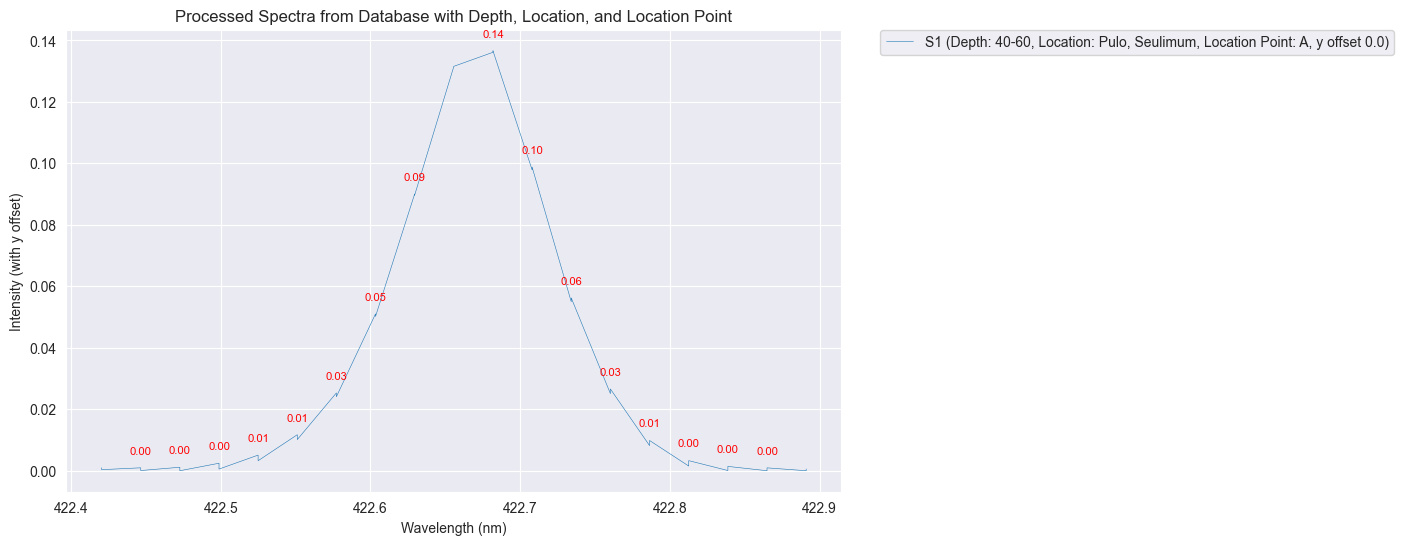


Wavelength (nm)      Intensity   
--------------------------------
422.44659            0.00094983  
422.47272            0.00112784  
422.49887            0.00243088  
422.52499            0.00507925  
422.55115            0.01171081  
422.57727            0.02530988  
422.60342            0.05101947  
422.62955            0.09002070  
422.68185            0.13661675  
422.70801            0.09877731  
422.73416            0.05621160  
422.76031            0.02659153  
422.78647            0.00983900  
422.81262            0.00327760  
422.83878            0.00140668  
422.86493            0.00093199  
Plot spektrum yang diproses telah disimpan dalam format PDF dengan informasi depth, location, dan location_point.


In [8]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth, location, dan location_point
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan location_point
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_processed_spectra(db_path, sample_names, output_pdf='processed_spectra_plot_with_metadata.pdf', lower_bound=None, upper_bound=None):
    plt.figure(figsize=(10, 6))
    offset = 1  # Offset untuk setiap sampel pada sumbu y
    all_peaks = []  # Untuk menyimpan semua puncak

    for i, sample_name in enumerate(sample_names):
        wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
        if len(wavelengths) > 0:
            # Menambahkan depth, location, dan location_point ke label pada plot
            plt.plot(wavelengths, intensities + i * offset, label=f'{sample_name} (Depth: {depth}, Location: {location}, Location Point: {location_point}, y offset {i * offset:.1f})', linewidth=0.4)
            
            # Mencari puncak dalam data intensitas
            peaks, _ = find_peaks(intensities)
            for peak in peaks:
                plt.annotate(f'{intensities[peak]:.2f}', 
                             (wavelengths[peak], intensities[peak] + i * offset), 
                             textcoords="offset points", 
                             xytext=(0,10), 
                             ha='center', 
                             fontsize=8, 
                             color='red')
                all_peaks.append((wavelengths[peak], intensities[peak]))

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (with y offset)')
    plt.title('Processed Spectra from Database with Depth, Location, and Location Point')

    # Menempatkan legenda di luar kotak plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.grid(True)

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

    # Menampilkan plot
    plt.show()

    # Mencetak tabel puncak intensitas dan panjang gelombangnya
    print(f"\n{'Wavelength (nm)':<20} {'Intensity':<12}")
    print("-" * 32)
    for wl, intensity in all_peaks:
        print(f"{wl:<20} {intensity:<12.8f}")

# Path ke database baru
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 2)]  # Mengambil contoh 1 sampel

# Menentukan batas panjang gelombang
lower_bound = 422.4  # Contoh: batas bawah panjang gelombang
upper_bound = 422.9 

# Memproses dan menyimpan spektrum dengan batas panjang gelombang ke PDF, dengan depth, location, dan location_point
plot_and_save_processed_spectra(db_path, sample_names, 'processed_spectra_plot_with_bounds_and_metadata.pdf', lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam format PDF dengan informasi depth, location, dan location_point.")

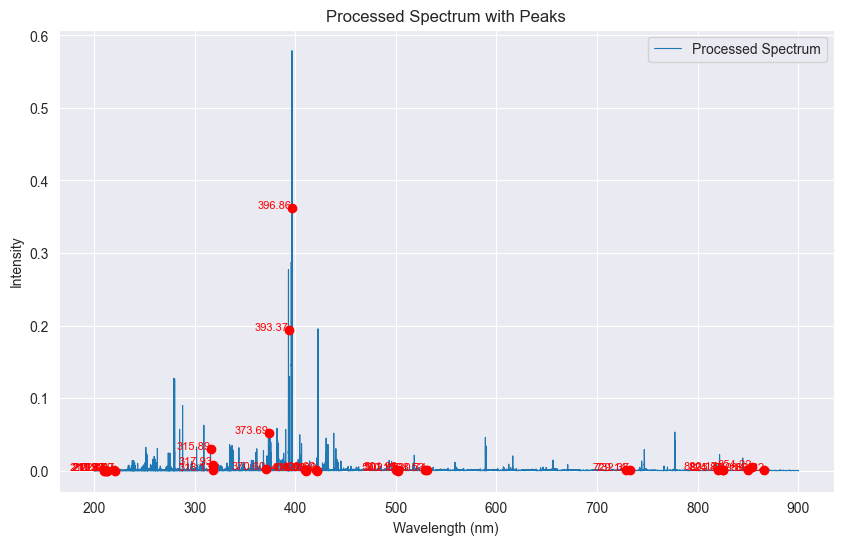

In [38]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum dari database
def get_processed_spectrum(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil panjang gelombang dan intensitas dari spektrum yang diproses
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([])

    # Pisahkan panjang gelombang dan intensitas
    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk mencari puncak spektrum berdasarkan panjang gelombang yang diberikan
def find_peaks_in_spectrum(wavelengths, intensities, peak_wavelengths, tolerance=0.1):
    peaks = []
    for peak_wl in peak_wavelengths:
        # Temukan panjang gelombang terdekat dalam spektrum yang diproses
        idx = np.argmin(np.abs(wavelengths - peak_wl))
        if np.abs(wavelengths[idx] - peak_wl) <= tolerance:
            peaks.append((wavelengths[idx], intensities[idx]))

    return peaks

# Fungsi untuk plot spektrum dan puncak
def plot_spectrum_with_peaks(wavelengths, intensities, peaks):
    plt.figure(figsize=(10, 6))

    # Plot spektrum
    plt.plot(wavelengths, intensities, label='Processed Spectrum', linewidth=0.8)

    # Plot puncak yang ditemukan
    for peak_wl, peak_intensity in peaks:
        plt.plot(peak_wl, peak_intensity, 'ro')  # Menambahkan titik merah untuk puncak
        plt.text(peak_wl, peak_intensity, f'{peak_wl:.2f}', color='red', fontsize=8, ha='right')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('Processed Spectrum with Peaks')
    plt.legend()
    plt.grid(True)

    # Simpan plot ke file PDF
    plt.savefig('spectrum_with_peaks.pdf', format='pdf', bbox_inches='tight')
    
    # Tampilkan plot
    plt.show()

# Panjang gelombang yang diberikan dalam tabel
peak_wavelengths = [210.324, 211.276, 211.315, 212.875, 213.151, 219.779, 220.861, 
                    315.887, 317.933, 318.128, 370.603, 373.690, 393.366, 396.847, 
                    409.710, 410.982, 411.028, 420.618, 422.007, 500.148, 501.997, 
                    502.114, 528.527, 530.722, 729.147, 732.389, 820.172, 824.880, 
                    825.473, 849.802, 854.209, 866.214]

# Path ke database spektrum yang diproses
db_path = 'processed_spectra.db'
sample_name = 'S3'  # Nama sampel yang ingin diproses

# Ambil spektrum dari database
wavelengths, intensities = get_processed_spectrum(db_path, sample_name)

# Cari puncak spektrum berdasarkan panjang gelombang yang diberikan
peaks = find_peaks_in_spectrum(wavelengths, intensities, peak_wavelengths)

# Plot spektrum dengan puncak yang ditemukan
plot_spectrum_with_peaks(wavelengths, intensities, peaks)


In [6]:
import sqlite3

# Fungsi untuk mencetak garis Ca II dari database dengan filter Jk dan gA, termasuk konversi untuk suhu plasma
def print_ca2_lines_with_conversions_for_boltzmann(db_nist):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Query untuk mengambil semua data yang berkaitan dengan Ca II (sp_num = 2 untuk ionisasi Ca II)
    # dan memastikan bahwa Jk dan gA tidak nol atau kosong
    query = """
        SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)", sp_num, "Ei(cm-1)"
        FROM spectrum_data
        WHERE sp_num = 1 
        AND J_k IS NOT NULL AND J_k != '' AND J_k != 0
        AND "gA(s^-1)" IS NOT NULL AND "gA(s^-1)" != '' AND "gA(s^-1)" != 0
        AND element = 'Ca'
    """
    cursor.execute(query)
    data = cursor.fetchall()

    conn.close()

    # Cetak data garis Ca II yang memenuhi filter, dan lakukan konversi yang diperlukan untuk suhu plasma
    if data:
        print(f"{'Wavelength (nm)':<20} {'Wavenumber (cm^-1)':<25} {'Energy (eV)':<15} {'J_k':<10} {'gA (s^-1)':<15}")
        print("-" * 100)
        for row in data:
            obs_wl, Ek, Jk, gA, sp_num, Ei = row
            # Konversi nilai dari string ke float untuk perhitungan
            obs_wl = float(obs_wl)  # Pastikan obs_wl adalah float
            Ei = float(Ei)  # Pastikan Ei adalah float
            
            # Konversi wavelength (nm) ke wavenumber (cm^-1)
            wavenumber = 1e7 / obs_wl  # Wavenumber (cm^-1)
            
            # Konversi excitation energy (Ei) dari cm^-1 ke eV
            energy_eV = Ei / 8065.54

            print(f"{obs_wl:<20} {wavenumber:<25} {energy_eV:<15} {Jk:<10} {gA:<15}")
    else:
        print("Tidak ada data untuk Ca II (sp_num = 2) dengan filter Jk != 0 dan gA != 0.")

# Path ke database NIST
db_nist = 'data1.db'

# Panggil fungsi untuk mencetak garis Ca II yang memenuhi syarat filter Jk != 0, gA != 0, dan menampilkan energi eksitasi
print_ca2_lines_with_conversions_for_boltzmann(db_nist)


Wavelength (nm)      Wavenumber (cm^-1)        Energy (eV)     J_k        gA (s^-1)      
----------------------------------------------------------------------------------------------------
215.08               46494.32769202157         0.0             1          1.8e+07        
220.073              45439.46781295297         0.0             1          4.59e+07       
227.546              43947.15793729619         0.0             1          9.03e+07       
239.856              41691.68167567207         0.0             1          5.01e+07       
272.165              36742.41728363309         0.0             1          8.1e+05        
299.496              33389.427571653716        1.8793411228510428 1          1.10e+08       
299.731              33363.249046645156        1.8858083897668352 2          1.20e+08       
299.964              33337.33381339094         1.8858083897668352 1          8.37e+07       
300.686              33257.28500828107         1.8989358431053593 2          3.8

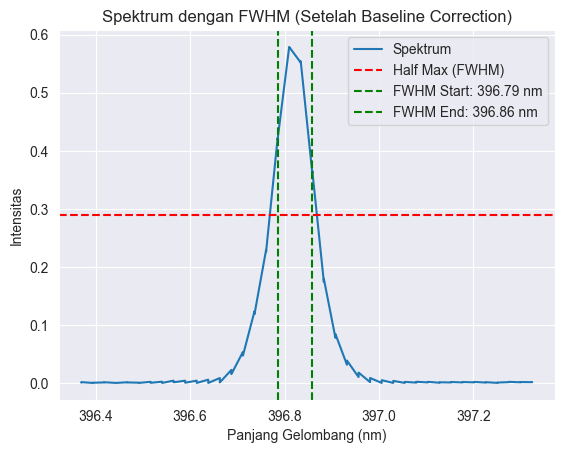

Densitas elektron: 2.07e+16 cm^-3


2.0714731358293588e+16

In [7]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk menghitung densitas plasma berdasarkan lebar Stark (FWHM)
def calculate_plasma_density(fwhm_stark, stark_broadening_parameter):
    """
    Menghitung densitas elektron berdasarkan lebar Stark.
    
    fwhm_stark: Full Width at Half Maximum (FWHM) dari garis spektrum (dalam nm)
    stark_broadening_parameter: Parameter dampak elektron (HWHM) untuk garis yang dianalisis
    
    Return: Densitas elektron (n_e) dalam cm^-3
    """
    if stark_broadening_parameter == 0:
        print("Stark broadening parameter tidak boleh nol.")
        return None

    # Rumus untuk menghitung densitas elektron dari FWHM
    electron_density = ((fwhm_stark / (2 * stark_broadening_parameter)) ** (3/2)) * 10**17
    return electron_density

# Fungsi untuk menghitung FWHM dari garis spektrum
def calculate_fwhm(wavelengths, intensities):
    """
    Menghitung Full Width at Half Maximum (FWHM) dari spektrum yang diberikan.
    Return: FWHM dalam nm
    """
    max_intensity = np.max(intensities)
    half_max = max_intensity / 2
    
    # Cari indeks untuk FWHM
    indices_above_half_max = np.where(intensities >= half_max)[0]
    if len(indices_above_half_max) < 2:
        print("Tidak cukup data untuk menghitung FWHM.")
        return None

    # Hitung FWHM sebagai selisih antara dua panjang gelombang pada nilai setengah puncak
    fwhm = wavelengths[indices_above_half_max[-1]] - wavelengths[indices_above_half_max[0]]
    
    # Dapatkan batas bawah dan atas untuk plot
    fwhm_bounds = (wavelengths[indices_above_half_max[0]], wavelengths[indices_above_half_max[-1]])
    
    return fwhm, fwhm_bounds

# Fungsi untuk baseline correction
def baseline_correction(intensities):
    """
    Menghilangkan baseline dari intensitas spektrum.
    Return: Intensitas yang telah dikoreksi baseline.
    """
    baseline = np.min(intensities)  # Ambil nilai minimum spektrum sebagai baseline
    corrected_intensities = intensities - baseline  # Kurangi baseline dari intensitas
    return corrected_intensities

# Fungsi untuk memplot spektrum dan menandai FWHM
def plot_spectrum_with_fwhm(wavelengths, intensities, fwhm_bounds):
    """
    Menampilkan plot spektrum dengan penandaan FWHM.
    """
    plt.plot(wavelengths, intensities, label='Spektrum')
    plt.axhline(np.max(intensities) / 2, color='r', linestyle='--', label='Half Max (FWHM)')
    plt.axvline(fwhm_bounds[0], color='g', linestyle='--', label=f'FWHM Start: {fwhm_bounds[0]:.2f} nm')
    plt.axvline(fwhm_bounds[1], color='g', linestyle='--', label=f'FWHM End: {fwhm_bounds[1]:.2f} nm')
    
    plt.title('Spektrum dengan FWHM (Setelah Baseline Correction)')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fungsi utama untuk menghitung densitas plasma dari garis 396.8471 nm
def plasma_density_from_stark(db_processed, sample_name, line_wavelength, stark_broadening_parameter):
    # Ambil spektrum yang diproses dari database
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
    """
    lower_bound = line_wavelength - 0.5  # Batas bawah panjang gelombang (di sekitar garis)
    upper_bound = line_wavelength + 0.5  # Batas atas panjang gelombang (di sekitar garis)
    cursor.execute(query, (sample_name, lower_bound, upper_bound))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name} pada panjang gelombang {line_wavelength}")
        return None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Lakukan baseline correction
    corrected_intensities = baseline_correction(intensities)

    # Hitung FWHM dari spektrum yang telah dikoreksi baseline
    fwhm, fwhm_bounds = calculate_fwhm(wavelengths, corrected_intensities)
    if fwhm is None:
        print("Gagal menghitung FWHM.")
        return None

    # Plot spektrum dengan FWHM
    plot_spectrum_with_fwhm(wavelengths, corrected_intensities, fwhm_bounds)

    # Hitung densitas elektron menggunakan FWHM dan parameter Stark
    electron_density = calculate_plasma_density(fwhm, stark_broadening_parameter)
    
    if electron_density is not None:
        print(f"Densitas elektron: {electron_density:.2e} cm^-3")
    
    return electron_density

# Contoh penggunaan
db_processed = 'processed_spectra.db'
sample_name = 'S3'

# Garis yang ingin dihitung (396.8471 nm)
line_wavelength = 396.8471  # Panjang gelombang garis Ca II
stark_broadening_parameter = 0.105  # Nilai HWHM dari tabel untuk garis ini

# Hitung densitas plasma berdasarkan garis Ca II
plasma_density_from_stark(db_processed, sample_name, line_wavelength, stark_broadening_parameter)

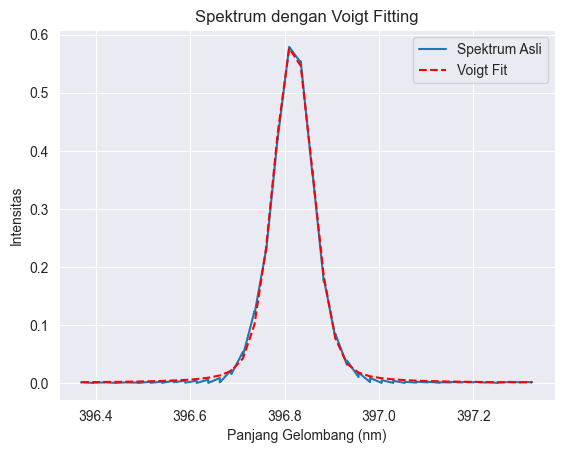

Hasil fitting Voigt: Amplitudo = 0.0679726854791448, Pusat = 396.8183 nm, Sigma (Gaussian) = 0.0363, Gamma (Lorentzian) = 0.0116


array([6.79726855e-02, 3.96818288e+02, 3.62836471e-02, 1.16204538e-02])

In [8]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# Fungsi Voigt
def voigt_profile(x, amp, center, sigma, gamma):
    """
    Fungsi untuk menghitung profil Voigt.
    
    amp: Amplitudo dari puncak
    center: Pusat puncak
    sigma: Lebar Gaussian
    gamma: Lebar Lorentzian
    
    Return: Nilai Voigt pada setiap titik x.
    """
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# Fungsi untuk baseline correction
def baseline_correction(intensities):
    """
    Menghilangkan baseline dari intensitas spektrum.
    Return: Intensitas yang telah dikoreksi baseline.
    """
    baseline = np.min(intensities)  # Ambil nilai minimum spektrum sebagai baseline
    corrected_intensities = intensities - baseline  # Kurangi baseline dari intensitas
    return corrected_intensities

# Fungsi untuk memplot spektrum dan fitting Voigt
def plot_spectrum_with_fitting(wavelengths, intensities, popt):
    """
    Menampilkan plot spektrum dengan fitting Voigt.
    """
    plt.plot(wavelengths, intensities, label='Spektrum Asli')
    plt.plot(wavelengths, voigt_profile(wavelengths, *popt), 'r--', label='Voigt Fit')
    
    plt.title('Spektrum dengan Voigt Fitting')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fungsi utama untuk fitting Voigt pada spektrum
def voigt_fitting_from_spectrum(db_processed, sample_name, line_wavelength):
    # Ambil spektrum yang diproses dari database
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
    """
    lower_bound = line_wavelength - 0.5  # Batas bawah panjang gelombang (di sekitar garis)
    upper_bound = line_wavelength + 0.5  # Batas atas panjang gelombang (di sekitar garis)
    cursor.execute(query, (sample_name, lower_bound, upper_bound))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name} pada panjang gelombang {line_wavelength}")
        return None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Lakukan baseline correction
    corrected_intensities = baseline_correction(intensities)

    # Estimasi parameter awal untuk fitting (amplitudo, pusat, sigma, gamma)
    initial_guess = [np.max(corrected_intensities), line_wavelength, 0.1, 0.1]

    # Fitting Voigt ke data spektrum
    try:
        popt, _ = curve_fit(voigt_profile, wavelengths, corrected_intensities, p0=initial_guess)
    except RuntimeError:
        print("Fitting gagal.")
        return None

    # Plot hasil fitting
    plot_spectrum_with_fitting(wavelengths, corrected_intensities, popt)

    # Tampilkan parameter hasil fitting
    print(f"Hasil fitting Voigt: Amplitudo = {popt[0]}, Pusat = {popt[1]:.4f} nm, Sigma (Gaussian) = {popt[2]:.4f}, Gamma (Lorentzian) = {popt[3]:.4f}")

    return popt

# Contoh penggunaan
db_processed = 'processed_spectra.db'
sample_name = 'S3'

# Garis yang ingin difitting (396.8471 nm)
line_wavelength = 396.8471  # Panjang gelombang garis Ca II

# Lakukan fitting Voigt pada spektrum
voigt_fitting_from_spectrum(db_processed, sample_name, line_wavelength)

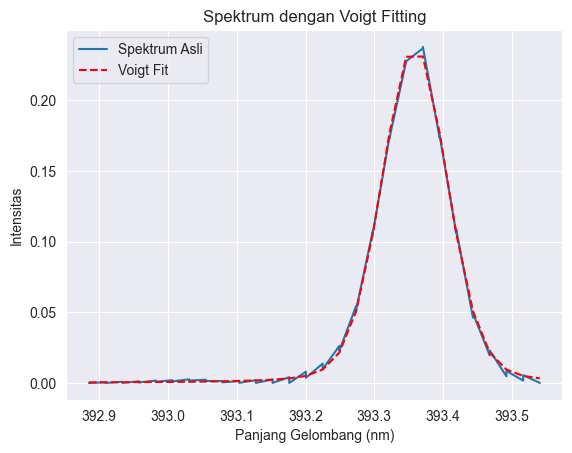

Hasil fitting Voigt: Amplitudo = 0.030196949923861904, Pusat = 393.3585 nm, Sigma (Gaussian) = 0.0432, Gamma (Lorentzian) = 0.0088
FWHM Voigt: 0.1115 nm
Stark Broadening Parameter: 0.028499999999999998 nm
Densitas elektron: 2.74e+17 cm^-3


In [36]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

def voigt_profile(x, amp, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def calculate_voigt_fwhm(sigma, gamma):
    fwhm = 0.5346 * (2 * gamma) + np.sqrt(0.2166 * (2 * gamma)**2 + (2.355 * sigma)**2)
    return fwhm

def calculate_plasma_density(fwhm_stark, stark_broadening_parameter):
    if stark_broadening_parameter == 0:
        return None
    electron_density = ((fwhm_stark / (2 * stark_broadening_parameter)) ** (3/2)) * 10**17
    return electron_density

def voigt_fitting_with_fwhm_and_density(db_processed, sample_name, line_wavelength, stark_broadening_parameter):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
    """
    search_width = 0.5
    cursor.execute(query, (sample_name, line_wavelength - search_width, line_wavelength + search_width))
    data = cursor.fetchall()
    conn.close()

    if not data:
        return None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Menentukan batas bawah dan atas berdasarkan titik minimum di sekitar puncak
    peak_idx = np.argmax(intensities)
    left_min_idx = np.argmin(intensities[:peak_idx])
    right_min_idx = np.argmin(intensities[peak_idx:]) + peak_idx

    # Mengambil data dalam batas terendah yang ditemukan
    wavelengths = wavelengths[left_min_idx:right_min_idx + 1]
    intensities = intensities[left_min_idx:right_min_idx + 1]
    corrected_intensities = intensities - np.min(intensities)

    # Parameter awal untuk fitting Voigt
    initial_guess = [np.max(corrected_intensities), line_wavelength, 0.1, 0.1]

    try:
        popt, _ = curve_fit(voigt_profile, wavelengths, corrected_intensities, p0=initial_guess)
    except RuntimeError:
        return None

    plot_spectrum_with_fitting(wavelengths, corrected_intensities, popt)

    amp, center, sigma, gamma = popt
    print(f"Hasil fitting Voigt: Amplitudo = {amp}, Pusat = {center:.4f} nm, Sigma (Gaussian) = {sigma:.4f}, Gamma (Lorentzian) = {gamma:.4f}")

    fwhm_voigt = calculate_voigt_fwhm(sigma, gamma)
    print(f"FWHM Voigt: {fwhm_voigt:.4f} nm")
    print(f"Stark Broadening Parameter: {stark_broadening_parameter} nm")
    electron_density = calculate_plasma_density(fwhm_voigt, stark_broadening_parameter)
    print(f"Densitas elektron: {electron_density:.2e} cm^-3")

    return popt, fwhm_voigt, electron_density

def plot_spectrum_with_fitting(wavelengths, intensities, popt):
    plt.plot(wavelengths, intensities, label='Spektrum Asli')
    plt.plot(wavelengths, voigt_profile(wavelengths, *popt), 'r--', label='Voigt Fit')
    plt.title('Spektrum dengan Voigt Fitting')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.legend()
    plt.grid(True)
    plt.show()

db_processed = 'processed_spectra.db'
sample_name = 'S1'
line_wavelength = 393.37061
#line_wavelength =396.83429
stark_broadening_parameter = 0.57/20

voigt_params, fwhm_voigt, electron_density = voigt_fitting_with_fwhm_and_density(db_processed, sample_name, line_wavelength, stark_broadening_parameter)

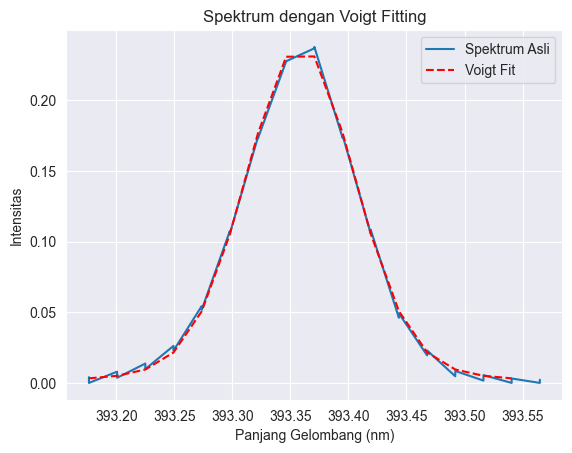

Hasil fitting Voigt: Amplitudo = 0.030215357755804976, Pusat = 393.3585 nm, Sigma (Gaussian) = 0.0432, Gamma (Lorentzian) = 0.0089
FWHM Voigt: 0.1115 nm
Densitas elektron: 2.73e+17 cm^-3


In [38]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

def voigt_profile(x, amp, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def calculate_voigt_fwhm(sigma, gamma):
    fwhm = 0.5346 * (2 * gamma) + np.sqrt(0.2166 * (2 * gamma)**2 + (2.355 * sigma)**2)
    return fwhm

def calculate_plasma_density(fwhm_stark, stark_broadening_parameter):
    if stark_broadening_parameter == 0:
        return None
    electron_density = ((fwhm_stark / (2 * stark_broadening_parameter)) ** (3/2)) * 10**17
    return electron_density

def voigt_fitting_with_fwhm_and_density(db_processed, sample_name, line_wavelength, stark_broadening_parameter):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
    """
    search_width = 0.2
    cursor.execute(query, (sample_name, line_wavelength - search_width, line_wavelength + search_width))
    data = cursor.fetchall()
    conn.close()

    if not data:
        return None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Finding the region of minimum intensity around the peak for better background selection
    peak_idx = np.argmax(intensities)
    baseline_left_idx = np.argmin(intensities[:peak_idx])  # Left side baseline
    baseline_right_idx = np.argmin(intensities[peak_idx:]) + peak_idx  # Right side baseline

    # Limit the fitting to the true peak region bounded by baseline minimum points
    wavelengths_fit = wavelengths[baseline_left_idx:baseline_right_idx + 1]
    intensities_fit = intensities[baseline_left_idx:baseline_right_idx + 1]
    corrected_intensities = intensities_fit - np.min(intensities_fit)

    # Initial guess for Voigt parameters
    initial_guess = [np.max(corrected_intensities), line_wavelength, 0.1, 0.1]

    try:
        popt, _ = curve_fit(voigt_profile, wavelengths_fit, corrected_intensities, p0=initial_guess)
    except RuntimeError:
        return None

    plot_spectrum_with_fitting(wavelengths, intensities, wavelengths_fit, corrected_intensities, popt)

    amp, center, sigma, gamma = popt
    fwhm_voigt = calculate_voigt_fwhm(sigma, gamma)
    electron_density = calculate_plasma_density(fwhm_voigt, stark_broadening_parameter)

    print(f"Hasil fitting Voigt: Amplitudo = {amp}, Pusat = {center:.4f} nm, Sigma (Gaussian) = {sigma:.4f}, Gamma (Lorentzian) = {gamma:.4f}")
    print(f"FWHM Voigt: {fwhm_voigt:.4f} nm")
    print(f"Densitas elektron: {electron_density:.2e} cm^-3")

    return popt, fwhm_voigt, electron_density

def plot_spectrum_with_fitting(wavelengths, intensities, wavelengths_fit, corrected_intensities, popt):
    plt.plot(wavelengths, intensities, label='Spektrum Asli')
    plt.plot(wavelengths_fit, voigt_profile(wavelengths_fit, *popt), 'r--', label='Voigt Fit')
    plt.title('Spektrum dengan Voigt Fitting')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Database and parameters
db_processed = 'processed_spectra.db'
sample_name = 'S1'
line_wavelength = 393.37061
stark_broadening_parameter = 0.57 / 20

voigt_params, fwhm_voigt, electron_density = voigt_fitting_with_fwhm_and_density(
    db_processed, sample_name, line_wavelength, stark_broadening_parameter
)

In [13]:
import sqlite3
import numpy as np

# Constants
k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
hc_in_eVnm = 1239.841984  # hc in eV·nm

def fetch_nist_data(db_path, nist_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    nist_data = []

    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)", "g_k"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        
        if result:
            obs_wl, Ek, gA, g_k = result
            try:
                obs_wl = float(obs_wl)  # Ensure obs_wl is float
                Ek_eV = float(Ek) / 8065.544  # Convert cm⁻¹ to eV
                Aki = float(gA) / float(g_k) if g_k != 0 else None  # Calculate Aki if g_k is valid
                if Aki is not None:
                    nist_data.append((obs_wl, Ek_eV, g_k, Aki))
                    print(f"Wavelength: {obs_wl} nm, Ek: {Ek_eV:.4f} eV, g_k: {g_k}, Aki: {Aki:.2e}")
                else:
                    print(f"Skipping due to missing g_k value for wavelength {obs_wl}")
            except ValueError:
                print(f"Invalid data for wavelength {obs_wl} nm")
        else:
            print(f"No data found for wavelength {wl}")

    conn.close()
    return nist_data

# Function to fetch integrated intensities for experimental wavelengths
def fetch_integrated_intensity(db_path, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    intensities = []
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities_list = zip(*results)
            integrated_intensity = np.trapz(intensities_list, wavelengths)
            intensities.append(integrated_intensity)
            print(f"Integrated intensity for wavelength {wl_exp}: {integrated_intensity}")
        else:
            print(f"No intensity data found for wavelength {wl_exp}")
            intensities.append(None)
    conn.close()
    return intensities

# Function to calculate the partition function Z(T) for the neutral atom
def calculate_partition_function(T_e, nist_data):
    Z_neutral = sum(g * np.exp(-Ek / (k_B * T_e)) for _, Ek, g, _ in nist_data if Ek is not None)
    print(f"Partition function Z at T_e={T_e} K: {Z_neutral}")
    return Z_neutral

# Main function to calculate concentration
def calculate_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths):
    exp_intensities = fetch_integrated_intensity('processed_spectra.db', sample_name, exp_wavelengths)
    nist_data = fetch_nist_data('data1.db', nist_wavelengths)

    print("\nStarting concentration calculations...")

    # Calculate partition function for neutral state
    Z_neutral = calculate_partition_function(T_e, nist_data)

    # Calculate concentrations based on intensities and partition function
    concentration_results = []
    total_population = 0
    for i, (wl, Ek, g, Aki) in enumerate(nist_data):
        if Ek is not None and g is not None and exp_intensities[i] is not None:
            try:
                wl = float(wl)  # Ensure wl is float for correct calculations
                N_rel = (exp_intensities[i] * wl) / (g * Aki * np.exp(-Ek / (k_B * T_e)))
                concentration_results.append((wl, exp_intensities[i], Ek, N_rel))
                total_population += N_rel
                print(f"Relative population N_rel for wavelength {wl}: {N_rel}")
            except ZeroDivisionError:
                print(f"Skipping calculation for wavelength {wl} due to zero division in data.")
        else:
            print(f"Skipping calculation for wavelength {wl} due to missing data.")

    # Convert relative populations to concentration percentages
    concentration_percentages = [(wl, (N_rel / total_population) * 100) for wl, _, _, N_rel in concentration_results]

    print("\nConcentration results (as percentage of total population):")
    for wl, concentration in concentration_percentages:
        print(f"Wavelength {wl}: {concentration:.2f}%")

# Example usage
T_e = 8000  # Electron temperature in Kelvin
n_e = 1e17  # Electron density in cm^-3
sample_name = 'S1'
exp_wavelengths = [
    237.34903, 309.24808, 247.84897, 422.6557, 430.22849, 283.51328, 311.9639,
    324.7366, 327.3847, 248.78934, 272.06, 656.18134, 670.73297, 610.263,
    279.52127, 280.24957, 257.59055, 259.35477, 589.54755, 401.2453, 389.14474,
    777.44952, 844.62415, 251.61142, 212.38974, 460.70947, 481.27179, 334.90216,
    323.63953, 318.48312, 438.32062, 243.49678, 766.43793, 769.87225, 455.37152,
    493.36807, 208.62665, 262.14273, 459.36902, 466.19803
]
nist_wavelengths = [
    237.3349, 309.27099, 247.85612, 422.673, 430.253, 283.563159, 311.864905,
    324.754, 327.3957, 248.81423, 272.09021, 656.27097, 670.776, 610.354,
    279.5528, 280.2704, 257.61038, 259.372098, 589.592424, 401.225, 389.151,
    777.417, 844.625, 251.6113, 212.412, 460.7331, 481.1881, 334.90327,
    323.61189, 318.4225, 438.3897, 243.3982, 766.489913, 769.896456, 455.4033,
    493.4077, 208.6779, 262.0571, 459.403, 466.188
]
calculate_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths)

Integrated intensity for wavelength 237.34903: 0.0011741076090000023
Integrated intensity for wavelength 309.24808: 0.009505034816466553
Integrated intensity for wavelength 247.84897: 0.0006360237169533803
Integrated intensity for wavelength 422.6557: 0.01675449952500866
Integrated intensity for wavelength 430.22849: 0.0027576031060237574
Integrated intensity for wavelength 283.51328: 0.0006769518897456494
Integrated intensity for wavelength 311.9639: 0.0005555620470412047
Integrated intensity for wavelength 324.7366: 0.0009167972518287159
Integrated intensity for wavelength 327.3847: 0.0005568912195807719
Integrated intensity for wavelength 248.78934: 0.0007156388353281135
Integrated intensity for wavelength 272.06: 0.0007044487396311125
Integrated intensity for wavelength 656.18134: 0.002519888127534963
Integrated intensity for wavelength 670.73297: 0.001868440744709362
Integrated intensity for wavelength 610.263: 0.00038477967637749646
Integrated intensity for wavelength 279.52127: 

In [9]:
import sqlite3
import numpy as np

# Constants
k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
hc_in_eVnm = 1239.841984  # hc in eV·nm
def fetch_integrated_intensity(db_path, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    intensities = []
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities_list = zip(*results)
            integrated_intensity = np.trapz(intensities_list, wavelengths)
            intensities.append(integrated_intensity)
            print(f"Integrated intensity for wavelength {wl_exp}: {integrated_intensity}")
        else:
            print(f"No intensity data found for wavelength {wl_exp}")
            intensities.append(None)
    conn.close()
    return intensities

def fetch_nist_data(db_path, nist_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    nist_data = []

    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)", "g_k"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        
        if result:
            obs_wl, Ek, gA, g_k = result
            try:
                Ek_eV = float(Ek) / 8065.544  # Convert cm⁻¹ to eV
                Aki = float(gA) / float(g_k) if g_k != 0 else None  # Calculate Aki if g_k is valid
                if Aki is not None:
                    nist_data.append((obs_wl, Ek_eV, g_k, Aki))
                    print(f"Wavelength: {obs_wl} nm, Ek: {Ek_eV:.4f} eV, g_k: {g_k}, Aki: {Aki:.2e}")
                else:
                    print(f"Skipping due to missing g_k value for wavelength {obs_wl}")
            except ValueError:
                print(f"Invalid data for wavelength {obs_wl} nm")
        else:
            print(f"No data found for wavelength {wl}")

    conn.close()
    return nist_data

# Example usage
db_path = 'data1.db'
nist_wavelengths = [422.673, 428.301, 429.899, 430.774, 442.544]  # Sample wavelengths to check
nist_data = fetch_nist_data(db_path, nist_wavelengths)

# Display summary of NIST data found
if nist_data:
    print("\nNIST data summary:")
    for data in nist_data:
        print(data)
else:
    print("No valid NIST data found for the specified wavelengths.")

Wavelength: 422.673 nm, Ek: 2.9325 eV, g_k: 3, Aki: 2.18e+08
Wavelength: 428.301 nm, Ek: 4.7798 eV, g_k: 5, Aki: 4.34e+07
Wavelength: 429.899 nm, Ek: 4.7690 eV, g_k: 3, Aki: 4.67e+07
Wavelength: 430.774 nm, Ek: 4.7632 eV, g_k: 1, Aki: 1.99e+08
Wavelength: 442.544 nm, Ek: 4.6802 eV, g_k: 3, Aki: 4.97e+07

NIST data summary:
('422.673', 2.932511929759481, 3, 218000000.0)
('428.301', 4.779783979853064, 5, 43400000.0)
('429.899', 4.76902835072253, 3, 46666666.666666664)
('430.774', 4.763168237629104, 1, 199000000.0)
('442.544', 4.680179910989265, 3, 49666666.666666664)


In [12]:
import sqlite3
import numpy as np
import pandas as pd

# Constants
k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
hc_in_eVnm = 1239.841984  # hc in eV·nm
m_e = 9.10938356e-31  # Electron mass in kg
h = 6.62607015e-34  # Planck's constant in Js

def fetch_nist_data(db_path, nist_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    nist_data = []

    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)", "g_k", "sp_num", "element"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        
        if result:
            # Ensure 6-tuple by adding `None` if values are missing
            result = tuple(result) + (None,) * (6 - len(result))
            obs_wl, Ek, gA, g_k, sp_num, element = result
            
            try:
                Ek_eV = float(Ek) / 8065.544 if Ek else None  # Convert cm⁻¹ to eV if Ek is present
                Aki = float(gA) / float(g_k) if g_k else None  # Calculate Aki if g_k is valid
                
                if Aki is not None and Ek_eV is not None:
                    nist_data.append((element, obs_wl, Ek_eV, g_k, Aki, sp_num))
            except ValueError:
                print(f"Invalid data for wavelength {obs_wl} nm")
        else:
            print(f"No complete data found for wavelength {wl}")

    conn.close()
    return nist_data

def fetch_integrated_intensity(db_path, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    intensities = []
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities_list = zip(*results)
            integrated_intensity = np.trapz(intensities_list, wavelengths)
            intensities.append(integrated_intensity)
            print(f"Integrated intensity for wavelength {wl_exp}: {integrated_intensity}")
        else:
            print(f"No intensity data found for wavelength {wl_exp}")
            intensities.append(None)
    conn.close()
    return intensities

def calculate_partition_function(T_e, nist_data, sp_num):
    return sum(
        g_k * np.exp(-Ek / (k_B * T_e)) 
        for _, _, Ek, g_k, _, sp in nist_data 
        if Ek is not None and g_k is not None and sp == sp_num
    )

def load_ionization_energies(file_path):
    ionization_data = {}
    df = pd.read_csv(file_path)
    
    for _, row in df.iterrows():
        element = row['Isoel. Seq.'].strip('"= ')
        ion_stage = int(row['Ion Charge'].strip('"= '))
        try:
            ion_energy = float(row['Ionization Energy (eV)'].strip('"= '))
            ionization_data[(element, ion_stage)] = ion_energy
        except ValueError:
            print(f"Skipping row with invalid ionization energy for element {element}")
    
    return ionization_data

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    if Z_neutral == 0 or Z_ion == 0 or n_e == 0:
        print("Warning: One of Z_neutral, Z_ion, or n_e is zero. Cannot proceed with Saha equation.")
        return 0
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

def calculate_total_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths, ionization_data):
    exp_intensities = fetch_integrated_intensity('processed_spectra.db', sample_name, exp_wavelengths)
    nist_data = fetch_nist_data('data1.db', nist_wavelengths)
    
    grouped_data = {}
    for element, obs_wl, Ek, g_k, Aki, sp_num in nist_data:
        if element not in grouped_data:
            grouped_data[element] = []
        grouped_data[element].append((obs_wl, Ek, g_k, Aki, sp_num))
    
    for element, data in grouped_data.items():
        Z_neutral = calculate_partition_function(T_e, data, sp_num=1)
        ionization_energy = ionization_data.get((element, 1))

        if ionization_energy:
            print(f"Ionization energy for {element} I -> II: {ionization_energy} eV")
        else:
            print(f"Ionization energy for {element} not found.")
            continue

        Z_ion = calculate_partition_function(T_e, data, sp_num=2)
        ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, ionization_energy) if Z_neutral > 0 and Z_ion > 0 else 0

        neutral_population = 0
        ionized_population = ionization_ratio * neutral_population

        concentration_results = []
        total_population = 0

        for i, (wl, Ek, g_k, Aki, sp_num) in enumerate(data):
            if Ek is not None and g_k is not None and exp_intensities[i] is not None:
                try:
                    intensity = float(exp_intensities[i])
                    N_rel = (intensity * wl) / (g_k * Aki * np.exp(-Ek / (k_B * T_e)))
                    total_population += N_rel

                    if sp_num == 1:
                        neutral_population += N_rel
                    else:
                        ionized_population += N_rel

                    concentration_results.append((wl, intensity, Ek, N_rel, sp_num))
                except (TypeError, ValueError) as e:
                    print(f"Error processing wavelength {wl}: {e}")

        if total_population > 0:
            neutral_percent = (neutral_population / total_population) * 100
            ionized_percent = (ionized_population / total_population) * 100
            print(f"\n{element} | Total Neutral Concentration: {neutral_percent:.2f}% | Total Ionized Concentration: {ionized_percent:.2f}%")
        else:
            print(f"Total population for {element} is zero. Cannot calculate percentages.")

# Example usage
T_e = 8000  # Electron temperature in Kelvin
n_e = 1e17  # Electron density in cm^-3
sample_name = 'S1'
exp_wavelengths = [237.34903, 309.24808, 247.84897, 422.6557]
nist_wavelengths = [237.3349, 309.27099, 247.85612, 422.673]
ionization_file = 'ion.csv'
ionization_data = load_ionization_energies(ionization_file)

# Perform concentration calculation
calculate_total_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths, ionization_data)

Integrated intensity for wavelength 237.34903: 0.0011741076090000023
Integrated intensity for wavelength 309.24808: 0.009505034816466553
Integrated intensity for wavelength 247.84897: 0.0006360237169533803
Integrated intensity for wavelength 422.6557: 0.01675449952500866


ValueError: not enough values to unpack (expected 6, got 5)

In [65]:
import sqlite3
import csv

# Connect to SQLite database or create if it doesn't exist
db_path = 'ionization_data1.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create ionization_data table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS ionization_data (
        element TEXT,
        ion_stage INTEGER,
        ionization_energy REAL
    )
''')

# CSV file path
csv_file_path = 'ion.csv'

# Insert data from CSV
with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)

    for row in reader:
        try:
            # Extract and clean data
            element = row['El. Name'].strip().replace('"', '')
            sp_name = row['Sp. Name'].strip().replace('"', '')
            ion_charge = row['Ion Charge'].replace('"', '').replace('=', '').strip()
            ionization_energy = row['Ionization Energy (eV)'].replace('"', '').replace('=', '').strip()

            # Check for valid ionization energy
            if ionization_energy:
                ionization_energy = float(ionization_energy)
                ion_stage = int(ion_charge)  # Convert ion_charge to integer stage (0 for neutral, +1 for singly ionized, etc.)

                # Insert data into the database
                cursor.execute('''
                    INSERT INTO ionization_data (element, ion_stage, ionization_energy)
                    VALUES (?, ?, ?)
                ''', (element, ion_stage, ionization_energy))

        except ValueError as e:
            print(f"Skipping row with invalid data: {row}")
            continue

# Commit and close
conn.commit()
conn.close()
print("Database created successfully with ion stages.")

Database created successfully with ion stages.


In [66]:
import sqlite3

def print_ionization_data(db_path='ionization_data1.db'):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Retrieve all rows from the ionization_data table
    cursor.execute("SELECT element, ionization_stage, ionization_energy FROM ionization_data")
    rows = cursor.fetchall()

    # Print out each row
    print("Ionization Data:")
    print("-" * 40)
    print(f"{'Element':<12} {'Stage':<10} {'Ionization Energy (eV)'}")
    print("-" * 40)
    for row in rows:
        element, ionization_stage, ionization_energy = row
        print(f"{element:<12} {ionization_stage:<10} {ionization_energy:.4f}")

    # Close the database connection
    conn.close()

# Run the function to print ionization data
print_ionization_data()

OperationalError: no such column: ionization_stage